# Exploration and Comparison of Transformers for Image Classification

## Few-Shot Linear Probing using Data-efficient image Transformer (DeiT)

Linear Probing is an experiment that involes training a linear classifier on top of pre-trained frozen features of the model.

Few-Shot Learning involes showing the model only small number of images per class. For example, showing only 1 image per class makes it a one-shot learning.

For this experiment, **(1, 2, 4, 8, 16)** shots will be used.

### Data-efficient image Transformer (DeiT)

Distilled data-efficient Image Transformer (DeiT) model pre-trained and fine-tuned on ImageNet-1k (1 million images, 1,000 classes) at resolution 224x224. It was first introduced in the paper *Training data-efficient image transformers & distillation through attention by Touvron et al.*

https://arxiv.org/abs/2012.12877

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load DeiT image processor used for image pre-processing.

In [6]:
processor = get_backbone_processor(model_names['DeiT'])

Print the pre-processing operations done by the processor.

In [7]:
processor

DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [9]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [10]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [11]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [12]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [13]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for the experiments and print its settings.

Each model will have its teacher (RegNet) that will be trained using the same config.

First the teacher is trained, then its knowledge is used to distill DeiT.

In [3]:
config = Config(
    num_epochs=10, 
    lr=1e-3, 
    weight_decay=0
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.001,
 'num_epochs': 10,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0,
 'dropout_rate': 0.1,
 'early_stopping': {'enabled': False, 'patience': 3, 'delta': 0},
 'gradient_clipping': {'enabled': False, 'max_norm': 0},
 'scheduler': {'enabled': False,
  'warmup_epochs': 0,
  'eta_min': 0,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Create empty array to store dataset accuracies for each experiment.

In [19]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Few-Shot Linear Probing (n=1)


Model is shown only 1 image per class from the dataset.

#### RESISC45

In [15]:
teacher_resisc45_1 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
get_model_params(teacher_resisc45_1)

Parameters: 80.70M


In [17]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45_1,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00,  8.56it/s]


Epochs: 1/10 | train_loss: 4.6951 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]


Epochs: 2/10 | train_loss: 3.1662 | train_acc: 0.4000


100%|██████████| 6/6 [00:00<00:00, 21.03it/s]


Epochs: 3/10 | train_loss: 2.3593 | train_acc: 0.7778


100%|██████████| 6/6 [00:00<00:00, 20.26it/s]


Epochs: 4/10 | train_loss: 1.6001 | train_acc: 0.9556


100%|██████████| 6/6 [00:00<00:00, 20.76it/s]


Epochs: 5/10 | train_loss: 1.0767 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 20.95it/s]


Epochs: 6/10 | train_loss: 0.7392 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 21.23it/s]


Epochs: 7/10 | train_loss: 0.5587 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 21.33it/s]


Epochs: 8/10 | train_loss: 0.3789 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 20.55it/s]


Epochs: 9/10 | train_loss: 0.3684 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 19.95it/s]

Epochs: 10/10 | train_loss: 0.2120 | train_acc: 1.0000


In [18]:
deit_resisc45_1 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
get_model_params(deit_resisc45_1)

Parameters: 85.87M


In [20]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45_1,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_resisc45_1,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00,  8.51it/s]


Epochs: 1/10 | train_loss: 4.0721 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00,  8.80it/s]


Epochs: 2/10 | train_loss: 3.1428 | train_acc: 0.4444


100%|██████████| 6/6 [00:00<00:00,  8.83it/s]


Epochs: 3/10 | train_loss: 2.4408 | train_acc: 0.8889


100%|██████████| 6/6 [00:00<00:00,  8.82it/s]


Epochs: 4/10 | train_loss: 1.8170 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.85it/s]


Epochs: 5/10 | train_loss: 1.3075 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.72it/s]


Epochs: 6/10 | train_loss: 0.9010 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.79it/s]


Epochs: 7/10 | train_loss: 0.6327 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.80it/s]


Epochs: 8/10 | train_loss: 0.4406 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.83it/s]


Epochs: 9/10 | train_loss: 0.3273 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  8.82it/s]


Epochs: 10/10 | train_loss: 0.2643 | train_acc: 1.0000


In [21]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45_1,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:08<00:00, 11.48it/s]

test_loss: 2.8747 | test_acc: 0.3048


In [22]:
resisc45_accs.append(resisc45_acc)

In [23]:
get_top_5_accuracies(resisc45_per_class_acc)

[('circular farmland', 0.8493150684931506),
 ('meadow', 0.6384615384615384),
 ('cloud', 0.6289308176100629),
 ('harbor', 0.6126760563380281),
 ('ship', 0.6074074074074074)]

In [24]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('commercial area', 0.007142857142857143),
 ('palace', 0.02857142857142857),
 ('railway station', 0.032467532467532464),
 ('airport', 0.043209876543209874),
 ('railway', 0.05714285714285714)]

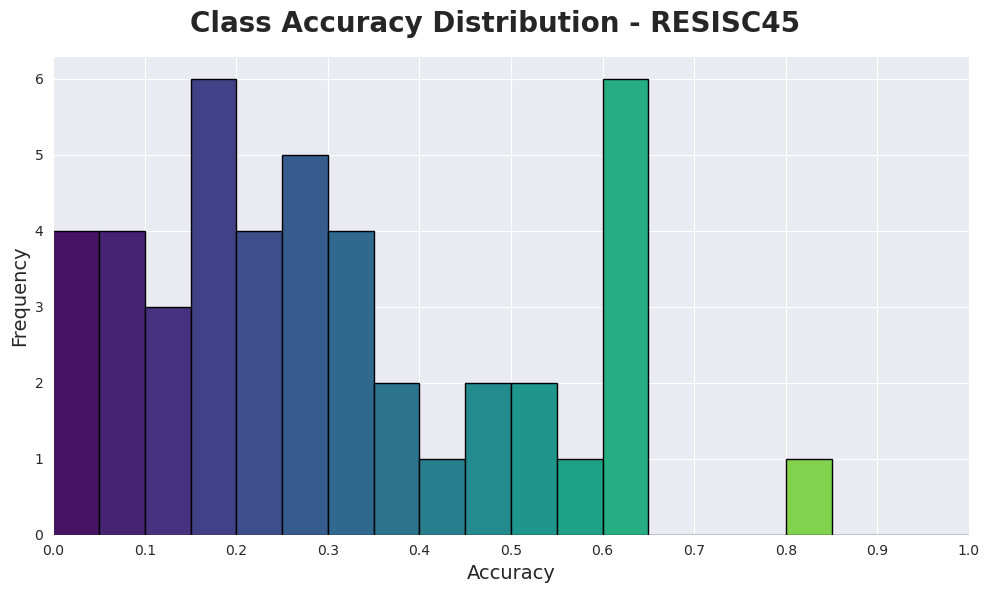

In [25]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [26]:
teacher_food101_1 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
get_model_params(teacher_food101_1)

Parameters: 80.87M


In [28]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101_1,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 13/13 [00:00<00:00, 13.54it/s]


Epochs: 1/10 | train_loss: 6.3056 | train_acc: 0.0099


100%|██████████| 13/13 [00:00<00:00, 13.71it/s]


Epochs: 2/10 | train_loss: 3.4713 | train_acc: 0.5545


100%|██████████| 13/13 [00:00<00:00, 13.80it/s]


Epochs: 3/10 | train_loss: 1.7834 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.62it/s]


Epochs: 4/10 | train_loss: 0.7978 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.79it/s]


Epochs: 5/10 | train_loss: 0.4523 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.67it/s]


Epochs: 6/10 | train_loss: 0.2117 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.76it/s]


Epochs: 7/10 | train_loss: 0.1462 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.61it/s]


Epochs: 8/10 | train_loss: 0.1130 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.38it/s]


Epochs: 9/10 | train_loss: 0.1080 | train_acc: 1.0000


100%|██████████| 13/13 [00:00<00:00, 13.30it/s]

Epochs: 10/10 | train_loss: 0.0669 | train_acc: 1.0000


In [29]:
deit_food101_1 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
get_model_params(deit_food101_1)

Parameters: 85.96M


In [31]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101_1,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_food101_1,
    few_shot=1
)

100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epochs: 1/10 | train_loss: 4.9188 | train_acc: 0.0000


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epochs: 2/10 | train_loss: 3.7257 | train_acc: 0.5248


100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epochs: 3/10 | train_loss: 2.7844 | train_acc: 0.9109


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epochs: 4/10 | train_loss: 1.9255 | train_acc: 0.9901


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epochs: 5/10 | train_loss: 1.2674 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epochs: 6/10 | train_loss: 0.8132 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epochs: 7/10 | train_loss: 0.5130 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epochs: 8/10 | train_loss: 0.3601 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epochs: 9/10 | train_loss: 0.2533 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

Epochs: 10/10 | train_loss: 0.1924 | train_acc: 1.0000


In [32]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101_1,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:52<00:00,  8.96it/s]


test_loss: 3.7197 | test_acc: 0.1985


In [33]:
food101_accs.append(food101_acc)

In [34]:
get_top_5_accuracies(food101_per_class_acc)

[('spaghetti carbonara', 0.972),
 ('pizza', 0.884),
 ('guacamole', 0.848),
 ('cup cakes', 0.812),
 ('edamame', 0.76)]

In [35]:
get_bottom_5_accuracies(food101_per_class_acc)

[('breakfast burrito', 0.0),
 ('dumplings', 0.0),
 ('hot dog', 0.0),
 ('waffles', 0.0),
 ('chocolate cake', 0.004)]

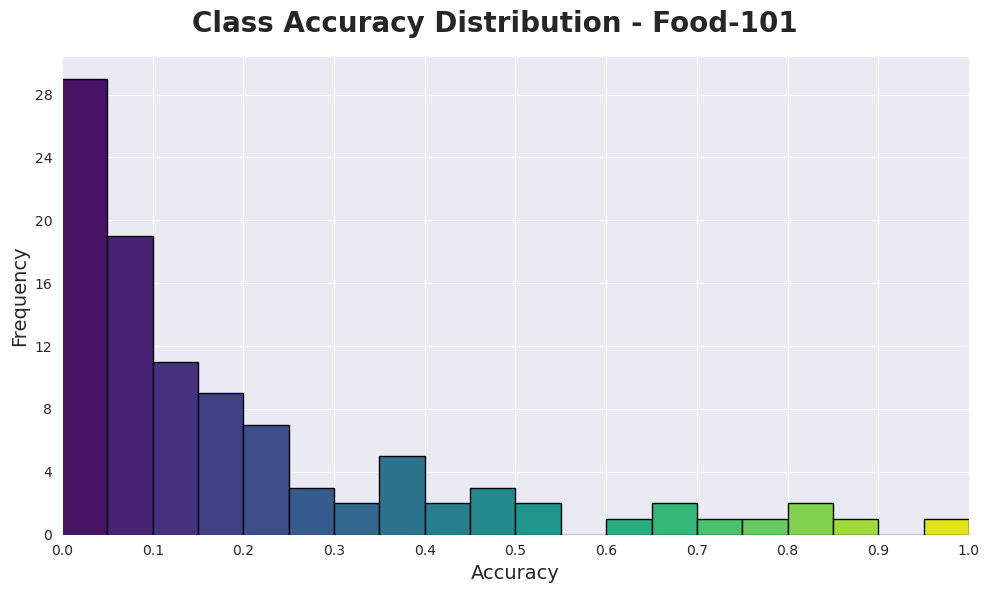

In [36]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [37]:
teacher_fer2013_1 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
get_model_params(teacher_fer2013_1)

Parameters: 80.59M


In [39]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013_1,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epochs: 1/10 | train_loss: 2.0054 | train_acc: 0.0000


100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


Epochs: 2/10 | train_loss: 1.5323 | train_acc: 0.8571


100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epochs: 3/10 | train_loss: 1.1219 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


Epochs: 4/10 | train_loss: 0.7862 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Epochs: 5/10 | train_loss: 0.5301 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


Epochs: 6/10 | train_loss: 0.3479 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


Epochs: 7/10 | train_loss: 0.2263 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epochs: 8/10 | train_loss: 0.1482 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


Epochs: 9/10 | train_loss: 0.0989 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]

Epochs: 10/10 | train_loss: 0.0677 | train_acc: 1.0000


In [40]:
deit_fer2013_1 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
get_model_params(deit_fer2013_1)

Parameters: 85.81M


In [42]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013_1,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_fer2013_1,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epochs: 1/10 | train_loss: 2.3347 | train_acc: 0.1429


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epochs: 2/10 | train_loss: 2.0800 | train_acc: 0.1429


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epochs: 3/10 | train_loss: 1.8506 | train_acc: 0.1429


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epochs: 4/10 | train_loss: 1.6488 | train_acc: 0.4286


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epochs: 5/10 | train_loss: 1.4766 | train_acc: 0.4286


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epochs: 6/10 | train_loss: 1.3355 | train_acc: 0.2857


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epochs: 7/10 | train_loss: 1.2250 | train_acc: 0.2857


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epochs: 8/10 | train_loss: 1.1417 | train_acc: 0.2857


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epochs: 9/10 | train_loss: 1.0797 | train_acc: 0.2857


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

Epochs: 10/10 | train_loss: 1.0318 | train_acc: 0.1429


In [43]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013_1,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:39<00:00, 11.33it/s]

test_loss: 2.3966 | test_acc: 0.1739


In [44]:
fer2013_accs.append(fer2013_acc)

In [45]:
fer2013_per_class_acc

{'angry': 0.002036659877800407,
 'disgust': 0.0,
 'fear': 0.0,
 'happy': 0.0,
 'sad': 0.0,
 'surprise': 0.0,
 'neutral': 0.9952076677316294}

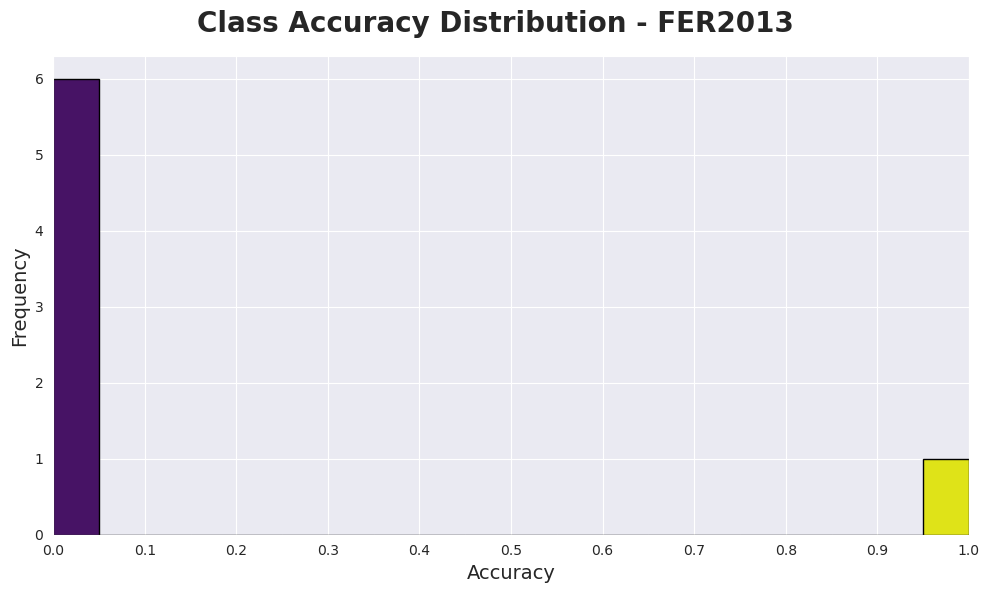

In [46]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [47]:
teacher_pcam_1 = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
get_model_params(teacher_pcam_1)

Parameters: 80.57M


In [49]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam_1,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Epochs: 1/10 | train_loss: 0.7147 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


Epochs: 2/10 | train_loss: 0.4028 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 53.99it/s]


Epochs: 3/10 | train_loss: 0.2234 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 55.18it/s]


Epochs: 4/10 | train_loss: 0.1241 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 37.69it/s]


Epochs: 5/10 | train_loss: 0.0701 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 55.93it/s]


Epochs: 6/10 | train_loss: 0.0409 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 55.66it/s]


Epochs: 7/10 | train_loss: 0.0251 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 54.32it/s]


Epochs: 8/10 | train_loss: 0.0161 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


Epochs: 9/10 | train_loss: 0.0108 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 55.96it/s]

Epochs: 10/10 | train_loss: 0.0076 | train_acc: 1.0000


In [50]:
deit_pcam_1 = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
get_model_params(deit_pcam_1)

Parameters: 85.80M


In [52]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam_1,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True, 
    teacher=teacher_pcam_1,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 25.77it/s]


Epochs: 1/10 | train_loss: 0.7280 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 26.13it/s]


Epochs: 2/10 | train_loss: 0.5633 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 27.22it/s]


Epochs: 3/10 | train_loss: 0.4348 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


Epochs: 4/10 | train_loss: 0.3398 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


Epochs: 5/10 | train_loss: 0.2704 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 27.07it/s]


Epochs: 6/10 | train_loss: 0.2182 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 27.48it/s]


Epochs: 7/10 | train_loss: 0.1773 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 27.29it/s]


Epochs: 8/10 | train_loss: 0.1443 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 27.43it/s]


Epochs: 9/10 | train_loss: 0.1173 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 24.38it/s]

Epochs: 10/10 | train_loss: 0.0953 | train_acc: 1.0000


In [53]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam_1,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:08<00:00, 11.12it/s]

test_loss: 0.7967 | test_acc: 0.4933


In [54]:
pcam_accs.append(pcam_acc)

In [55]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.41040815081447135,
 'lymph node tumor tissue': 0.5762960249129877}

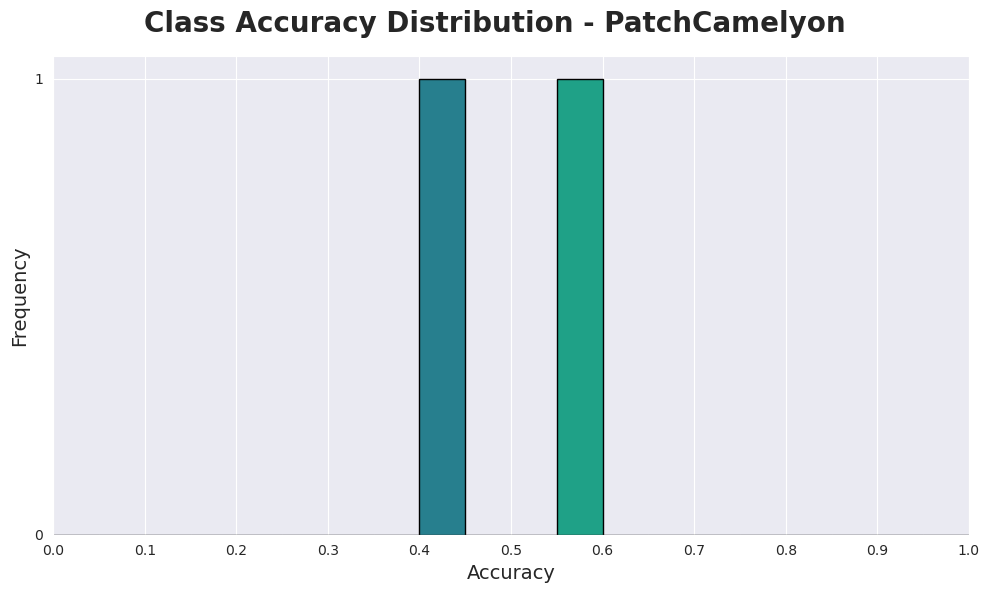

In [56]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [57]:
teacher_sun397_1 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
get_model_params(teacher_sun397_1)

Parameters: 81.77M


In [59]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397_1,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


Epochs: 1/10 | train_loss: 8.4884 | train_acc: 0.0000


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Epochs: 2/10 | train_loss: 2.3524 | train_acc: 0.6927


100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epochs: 3/10 | train_loss: 0.5174 | train_acc: 0.9849


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Epochs: 4/10 | train_loss: 0.1796 | train_acc: 1.0000


100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


Epochs: 5/10 | train_loss: 0.1081 | train_acc: 1.0000


100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epochs: 6/10 | train_loss: 0.0935 | train_acc: 1.0000


100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Epochs: 7/10 | train_loss: 0.0857 | train_acc: 1.0000


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Epochs: 8/10 | train_loss: 0.0563 | train_acc: 1.0000


100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epochs: 9/10 | train_loss: 0.0394 | train_acc: 1.0000


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]

Epochs: 10/10 | train_loss: 0.0369 | train_acc: 1.0000


In [60]:
deit_sun397_1 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
get_model_params(deit_sun397_1)

Parameters: 86.41M


In [62]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397_1,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_sun397_1,
    few_shot=1
)

100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


Epochs: 1/10 | train_loss: 6.4090 | train_acc: 0.0000


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Epochs: 2/10 | train_loss: 4.2954 | train_acc: 0.6045


100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Epochs: 3/10 | train_loss: 2.4530 | train_acc: 0.9950


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Epochs: 4/10 | train_loss: 1.1088 | train_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


Epochs: 5/10 | train_loss: 0.4852 | train_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Epochs: 6/10 | train_loss: 0.2449 | train_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


Epochs: 7/10 | train_loss: 0.1521 | train_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Epochs: 8/10 | train_loss: 0.1049 | train_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Epochs: 9/10 | train_loss: 0.0795 | train_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]

Epochs: 10/10 | train_loss: 0.0628 | train_acc: 1.0000


In [63]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397_1,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:10<00:00,  8.75it/s]


test_loss: 4.0468 | test_acc: 0.2553


In [64]:
sun397_accs.append(sun397_acc)

In [65]:
get_top_5_accuracies(sun397_per_class_acc)

[('arrival gate (outdoor)', 1.0),
 ('oilrig', 1.0),
 ('ladning deck', 0.96),
 ('volcano', 0.9473684210526315),
 ('underwater (coral reef)', 0.9396551724137931)]

In [66]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('abbey', 0.0),
 ('airport terminal', 0.0),
 ('atrium (public)', 0.0),
 ('balcony (interior)', 0.0),
 ('boat deck', 0.0)]

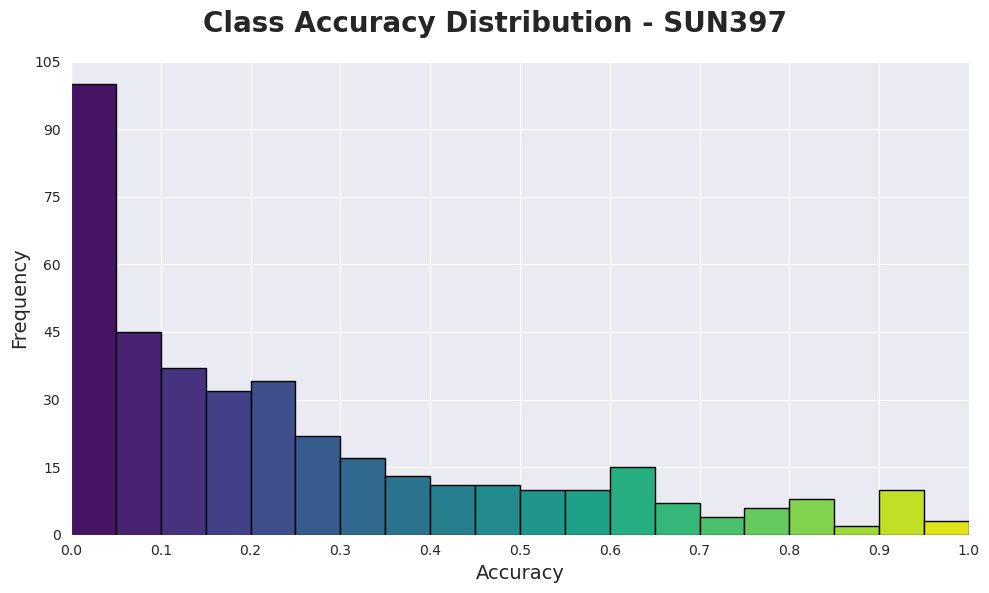

In [67]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [68]:
teacher_dtd_1 = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
get_model_params(teacher_dtd_1)

Parameters: 80.71M


In [70]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd_1,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00, 12.09it/s]


Epochs: 1/10 | train_loss: 4.6211 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00, 12.25it/s]


Epochs: 2/10 | train_loss: 3.1326 | train_acc: 0.2766


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]


Epochs: 3/10 | train_loss: 2.0487 | train_acc: 0.8298


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]


Epochs: 4/10 | train_loss: 1.4714 | train_acc: 0.9149


100%|██████████| 6/6 [00:00<00:00, 12.17it/s]


Epochs: 5/10 | train_loss: 0.8379 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.06it/s]


Epochs: 6/10 | train_loss: 0.6634 | train_acc: 0.9787


100%|██████████| 6/6 [00:00<00:00, 12.09it/s]


Epochs: 7/10 | train_loss: 0.3998 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.15it/s]


Epochs: 8/10 | train_loss: 0.2627 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 11.96it/s]


Epochs: 9/10 | train_loss: 0.1980 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.27it/s]

Epochs: 10/10 | train_loss: 0.1992 | train_acc: 1.0000


In [71]:
deit_dtd_1 = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
get_model_params(deit_dtd_1)

Parameters: 85.87M


In [73]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd_1,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_dtd_1,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


Epochs: 1/10 | train_loss: 4.0591 | train_acc: 0.0638


100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


Epochs: 2/10 | train_loss: 3.2014 | train_acc: 0.3191


100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


Epochs: 3/10 | train_loss: 2.4719 | train_acc: 0.8723


100%|██████████| 6/6 [00:00<00:00,  6.67it/s]


Epochs: 4/10 | train_loss: 1.8210 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


Epochs: 5/10 | train_loss: 1.2933 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


Epochs: 6/10 | train_loss: 0.8699 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


Epochs: 7/10 | train_loss: 0.5867 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


Epochs: 8/10 | train_loss: 0.4006 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  6.65it/s]


Epochs: 9/10 | train_loss: 0.2873 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

Epochs: 10/10 | train_loss: 0.2121 | train_acc: 1.0000


In [74]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd_1,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:26<00:00,  8.71it/s]

test_loss: 3.2116 | test_acc: 0.2612


In [75]:
dtd_accs.append(dtd_acc)

In [76]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.775),
 ('paisley', 0.775),
 ('dotted', 0.675),
 ('fibrous', 0.575),
 ('studded', 0.575)]

In [77]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('gauzy', 0.0),
 ('grid', 0.0),
 ('waffled', 0.0),
 ('crosshatched', 0.025),
 ('scaly', 0.025)]

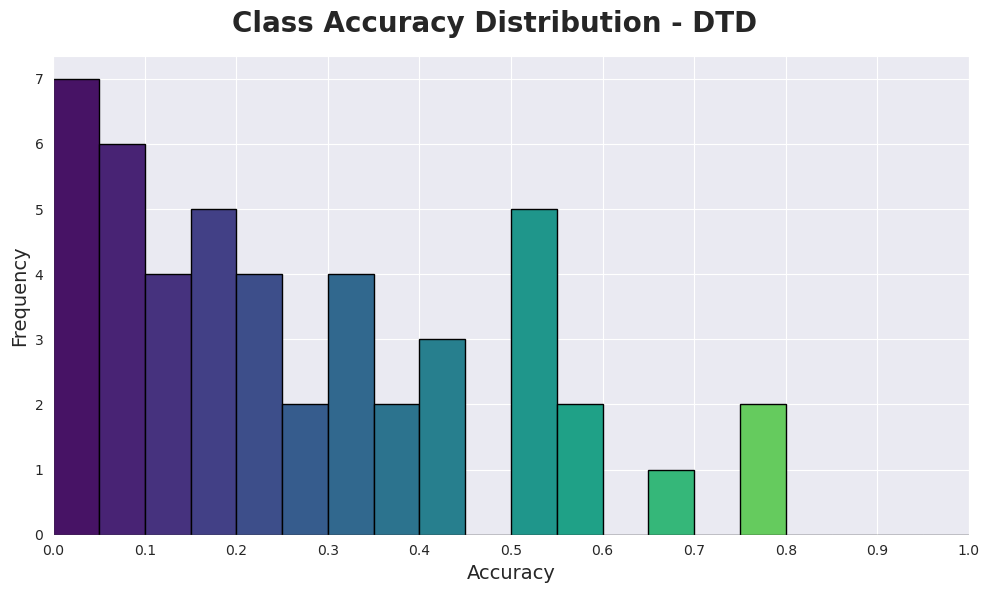

In [78]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=2)


Model is shown only 2 images per class from the dataset.

#### RESISC45

In [79]:
teacher_resisc45_2 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
get_model_params(teacher_resisc45_2)

Parameters: 80.70M


In [81]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45_2,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 12/12 [00:00<00:00, 20.72it/s]


Epochs: 1/10 | train_loss: 4.7081 | train_acc: 0.0111


100%|██████████| 12/12 [00:00<00:00, 21.04it/s]


Epochs: 2/10 | train_loss: 3.2851 | train_acc: 0.2667


100%|██████████| 12/12 [00:00<00:00, 21.03it/s]


Epochs: 3/10 | train_loss: 2.2655 | train_acc: 0.7000


100%|██████████| 12/12 [00:00<00:00, 21.36it/s]


Epochs: 4/10 | train_loss: 1.5233 | train_acc: 0.9000


100%|██████████| 12/12 [00:00<00:00, 21.14it/s]


Epochs: 5/10 | train_loss: 1.1125 | train_acc: 0.9667


100%|██████████| 12/12 [00:00<00:00, 21.01it/s]


Epochs: 6/10 | train_loss: 0.8807 | train_acc: 0.9778


100%|██████████| 12/12 [00:00<00:00, 21.13it/s]


Epochs: 7/10 | train_loss: 0.6234 | train_acc: 0.9889


100%|██████████| 12/12 [00:00<00:00, 21.06it/s]


Epochs: 8/10 | train_loss: 0.5269 | train_acc: 0.9889


100%|██████████| 12/12 [00:00<00:00, 20.94it/s]


Epochs: 9/10 | train_loss: 0.6503 | train_acc: 0.9667


100%|██████████| 12/12 [00:00<00:00, 20.83it/s]

Epochs: 10/10 | train_loss: 0.4240 | train_acc: 0.9778


In [82]:
deit_resisc45_2 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
get_model_params(deit_resisc45_2)

Parameters: 85.87M


In [84]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45_2,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_resisc45_2,
    few_shot=2
)

100%|██████████| 12/12 [00:01<00:00,  8.87it/s]


Epochs: 1/10 | train_loss: 4.0512 | train_acc: 0.0333


100%|██████████| 12/12 [00:01<00:00,  8.91it/s]


Epochs: 2/10 | train_loss: 2.9369 | train_acc: 0.5111


100%|██████████| 12/12 [00:01<00:00,  8.91it/s]


Epochs: 3/10 | train_loss: 2.1287 | train_acc: 0.8667


100%|██████████| 12/12 [00:01<00:00,  8.86it/s]


Epochs: 4/10 | train_loss: 1.4995 | train_acc: 0.9889


100%|██████████| 12/12 [00:01<00:00,  8.81it/s]


Epochs: 5/10 | train_loss: 1.0143 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.88it/s]


Epochs: 6/10 | train_loss: 0.7347 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.80it/s]


Epochs: 7/10 | train_loss: 0.5041 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.86it/s]


Epochs: 8/10 | train_loss: 0.3637 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.85it/s]


Epochs: 9/10 | train_loss: 0.2906 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  8.89it/s]

Epochs: 10/10 | train_loss: 0.2243 | train_acc: 1.0000


In [85]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45_2,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:07<00:00, 11.60it/s]

test_loss: 2.2864 | test_acc: 0.4581


In [86]:
resisc45_accs.append(resisc45_acc)

In [87]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9668874172185431),
 ('forest', 0.8904109589041096),
 ('circular farmland', 0.8082191780821918),
 ('cloud', 0.710691823899371),
 ('harbor', 0.6830985915492958)]

In [88]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.03571428571428571),
 ('basketball court', 0.14925373134328357),
 ('airport', 0.15432098765432098),
 ('lake', 0.16030534351145037),
 ('church', 0.17482517482517482)]

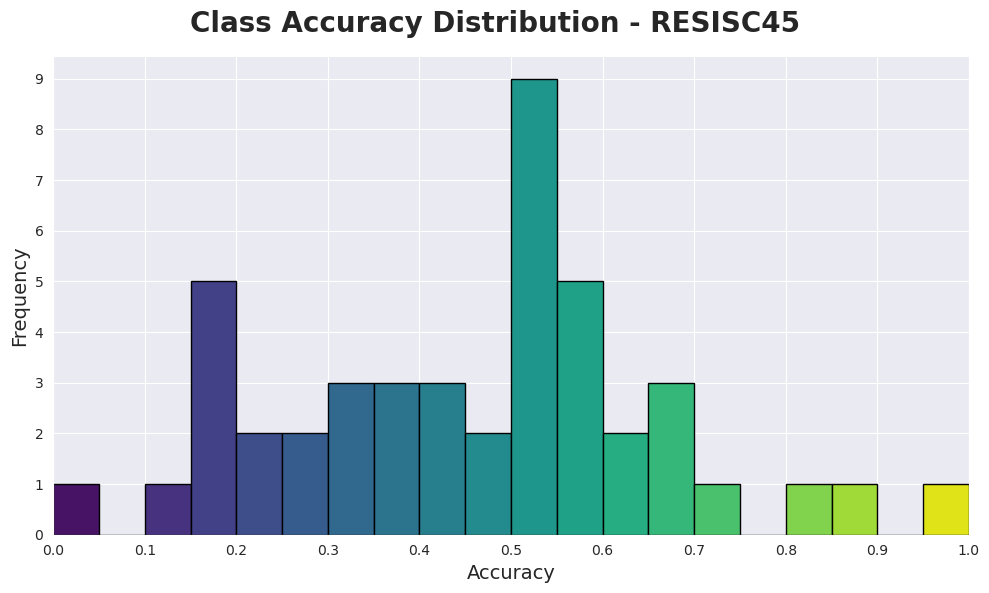

In [89]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [90]:
teacher_food101_2 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
get_model_params(teacher_food101_2)

Parameters: 80.87M


In [92]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101_2,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 26/26 [00:01<00:00, 13.60it/s]


Epochs: 1/10 | train_loss: 5.9847 | train_acc: 0.0000


100%|██████████| 26/26 [00:01<00:00, 13.56it/s]


Epochs: 2/10 | train_loss: 3.1821 | train_acc: 0.3911


100%|██████████| 26/26 [00:01<00:00, 13.78it/s]


Epochs: 3/10 | train_loss: 1.7677 | train_acc: 0.8663


100%|██████████| 26/26 [00:01<00:00, 13.67it/s]


Epochs: 4/10 | train_loss: 0.9430 | train_acc: 0.9802


100%|██████████| 26/26 [00:01<00:00, 13.58it/s]


Epochs: 5/10 | train_loss: 0.5106 | train_acc: 0.9901


100%|██████████| 26/26 [00:01<00:00, 13.66it/s]


Epochs: 6/10 | train_loss: 0.3930 | train_acc: 1.0000


100%|██████████| 26/26 [00:01<00:00, 13.73it/s]


Epochs: 7/10 | train_loss: 0.2713 | train_acc: 1.0000


100%|██████████| 26/26 [00:01<00:00, 13.71it/s]


Epochs: 8/10 | train_loss: 0.2201 | train_acc: 1.0000


100%|██████████| 26/26 [00:01<00:00, 13.69it/s]


Epochs: 9/10 | train_loss: 0.2072 | train_acc: 1.0000


100%|██████████| 26/26 [00:01<00:00, 13.77it/s]

Epochs: 10/10 | train_loss: 0.2032 | train_acc: 1.0000


In [93]:
deit_food101_2 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
get_model_params(deit_food101_2)

Parameters: 85.96M


In [95]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101_2,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_food101_2,
    few_shot=2
)

100%|██████████| 26/26 [00:03<00:00,  7.11it/s]


Epochs: 1/10 | train_loss: 4.8246 | train_acc: 0.0149


100%|██████████| 26/26 [00:03<00:00,  7.08it/s]


Epochs: 2/10 | train_loss: 3.4782 | train_acc: 0.5693


100%|██████████| 26/26 [00:03<00:00,  7.08it/s]


Epochs: 3/10 | train_loss: 2.4262 | train_acc: 0.9752


100%|██████████| 26/26 [00:03<00:00,  6.64it/s]


Epochs: 4/10 | train_loss: 1.5862 | train_acc: 0.9901


100%|██████████| 26/26 [00:03<00:00,  7.14it/s]


Epochs: 5/10 | train_loss: 0.9975 | train_acc: 0.9950


100%|██████████| 26/26 [00:03<00:00,  7.09it/s]


Epochs: 6/10 | train_loss: 0.6523 | train_acc: 1.0000


100%|██████████| 26/26 [00:03<00:00,  7.11it/s]


Epochs: 7/10 | train_loss: 0.4383 | train_acc: 1.0000


100%|██████████| 26/26 [00:03<00:00,  7.11it/s]


Epochs: 8/10 | train_loss: 0.3208 | train_acc: 1.0000


100%|██████████| 26/26 [00:03<00:00,  7.12it/s]


Epochs: 9/10 | train_loss: 0.2330 | train_acc: 1.0000


100%|██████████| 26/26 [00:03<00:00,  7.12it/s]

Epochs: 10/10 | train_loss: 0.1849 | train_acc: 1.0000


In [96]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101_2,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:51<00:00,  8.97it/s]


test_loss: 3.1216 | test_acc: 0.3014


In [97]:
food101_accs.append(food101_acc)

In [98]:
get_top_5_accuracies(food101_per_class_acc)

[('spaghetti carbonara', 0.952),
 ('guacamole', 0.912),
 ('pizza', 0.912),
 ('edamame', 0.908),
 ('spaghetti bolognese', 0.82)]

In [99]:
get_bottom_5_accuracies(food101_per_class_acc)

[('churros', 0.004),
 ('waffles', 0.012),
 ('panna cotta', 0.024),
 ('steak', 0.024),
 ('ravioli', 0.036)]

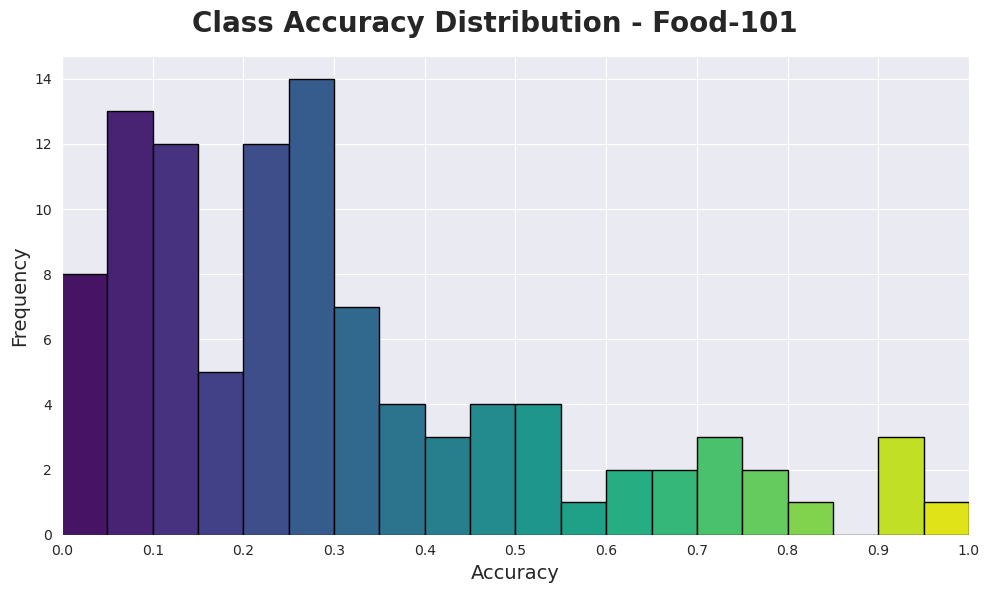

In [100]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [101]:
teacher_fer2013_2 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
get_model_params(teacher_fer2013_2)

Parameters: 80.59M


In [103]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013_2,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 2/2 [00:00<00:00, 15.97it/s]


Epochs: 1/10 | train_loss: 2.0743 | train_acc: 0.1429


100%|██████████| 2/2 [00:00<00:00, 21.32it/s]


Epochs: 2/10 | train_loss: 1.6864 | train_acc: 0.4286


100%|██████████| 2/2 [00:00<00:00, 21.47it/s]


Epochs: 3/10 | train_loss: 1.4114 | train_acc: 0.9286


100%|██████████| 2/2 [00:00<00:00, 21.61it/s]


Epochs: 4/10 | train_loss: 1.1214 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 21.61it/s]


Epochs: 5/10 | train_loss: 1.0612 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 22.49it/s]


Epochs: 6/10 | train_loss: 0.8186 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 21.61it/s]


Epochs: 7/10 | train_loss: 0.7437 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 21.38it/s]


Epochs: 8/10 | train_loss: 0.5347 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 20.35it/s]


Epochs: 9/10 | train_loss: 0.5894 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]

Epochs: 10/10 | train_loss: 0.3822 | train_acc: 1.0000


In [104]:
deit_fer2013_2 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
get_model_params(deit_fer2013_2)

Parameters: 85.81M


In [106]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013_2,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_fer2013_2,
    few_shot=2
)

100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Epochs: 1/10 | train_loss: 1.9682 | train_acc: 0.1429


100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Epochs: 2/10 | train_loss: 1.7774 | train_acc: 0.2143


100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Epochs: 3/10 | train_loss: 1.6218 | train_acc: 0.3571


100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Epochs: 4/10 | train_loss: 1.4989 | train_acc: 0.3571


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epochs: 5/10 | train_loss: 1.4059 | train_acc: 0.5000


100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Epochs: 6/10 | train_loss: 1.3054 | train_acc: 0.5000


100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Epochs: 7/10 | train_loss: 1.2159 | train_acc: 0.5714


100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Epochs: 8/10 | train_loss: 1.1827 | train_acc: 0.6429


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epochs: 9/10 | train_loss: 1.0393 | train_acc: 0.6429


100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

Epochs: 10/10 | train_loss: 0.9958 | train_acc: 0.6429


In [107]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013_2,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:39<00:00, 11.30it/s]

test_loss: 2.0535 | test_acc: 0.1527


In [108]:
fer2013_accs.append(fer2013_acc)

In [109]:
fer2013_per_class_acc

{'angry': 0.15478615071283094,
 'disgust': 0.2727272727272727,
 'fear': 0.05303030303030303,
 'happy': 0.007963594994311717,
 'sad': 0.1734006734006734,
 'surprise': 0.028846153846153848,
 'neutral': 0.4904153354632588}

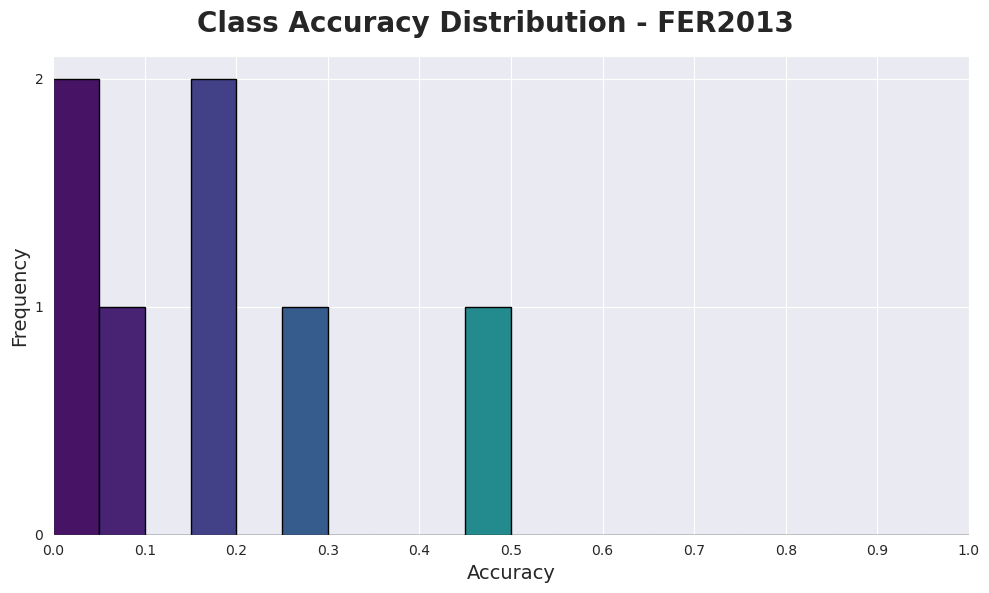

In [110]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [111]:
teacher_pcam_2 = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:
get_model_params(teacher_pcam_2)

Parameters: 80.57M


In [113]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam_2,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 1/1 [00:00<00:00, 21.21it/s]


Epochs: 1/10 | train_loss: 0.7333 | train_acc: 0.2500


100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


Epochs: 2/10 | train_loss: 0.5043 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 33.45it/s]


Epochs: 3/10 | train_loss: 0.3396 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 30.49it/s]


Epochs: 4/10 | train_loss: 0.2276 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 33.43it/s]


Epochs: 5/10 | train_loss: 0.1537 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 33.57it/s]


Epochs: 6/10 | train_loss: 0.1051 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 31.82it/s]


Epochs: 7/10 | train_loss: 0.0732 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 33.77it/s]


Epochs: 8/10 | train_loss: 0.0521 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 33.37it/s]


Epochs: 9/10 | train_loss: 0.0378 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 27.04it/s]

Epochs: 10/10 | train_loss: 0.0280 | train_acc: 1.0000


In [114]:
deit_pcam_2 = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
get_model_params(deit_pcam_2)

Parameters: 85.80M


In [116]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam_2,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True, 
    teacher=teacher_pcam_2,
    few_shot=2
)

100%|██████████| 1/1 [00:00<00:00, 14.52it/s]


Epochs: 1/10 | train_loss: 0.6298 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


Epochs: 2/10 | train_loss: 0.5533 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


Epochs: 3/10 | train_loss: 0.4872 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


Epochs: 4/10 | train_loss: 0.4291 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


Epochs: 5/10 | train_loss: 0.3777 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


Epochs: 6/10 | train_loss: 0.3321 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


Epochs: 7/10 | train_loss: 0.2920 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Epochs: 8/10 | train_loss: 0.2569 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epochs: 9/10 | train_loss: 0.2263 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

Epochs: 10/10 | train_loss: 0.1996 | train_acc: 1.0000


In [117]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam_2,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:05<00:00, 11.21it/s]

test_loss: 0.7616 | test_acc: 0.5205


In [118]:
pcam_accs.append(pcam_acc)

In [119]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.600451467268623,
 'lymph node tumor tissue': 0.4404958173047567}

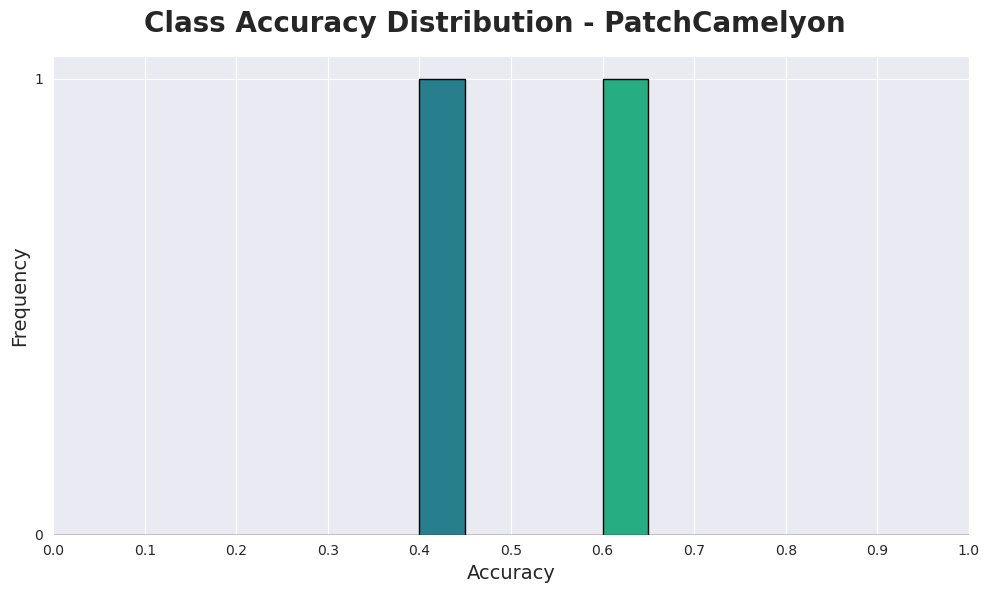

In [120]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [121]:
teacher_sun397_2 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
get_model_params(teacher_sun397_2)

Parameters: 81.77M


In [123]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397_2,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epochs: 1/10 | train_loss: 7.4727 | train_acc: 0.0050


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Epochs: 2/10 | train_loss: 2.0170 | train_acc: 0.6436


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


Epochs: 3/10 | train_loss: 0.7070 | train_acc: 0.9496


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epochs: 4/10 | train_loss: 0.3118 | train_acc: 0.9899


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epochs: 5/10 | train_loss: 0.2215 | train_acc: 0.9899


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epochs: 6/10 | train_loss: 0.1431 | train_acc: 0.9937


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epochs: 7/10 | train_loss: 0.1216 | train_acc: 0.9962


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epochs: 8/10 | train_loss: 0.1056 | train_acc: 0.9937


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epochs: 9/10 | train_loss: 0.0821 | train_acc: 0.9950


100%|██████████| 100/100 [00:07<00:00, 12.88it/s]

Epochs: 10/10 | train_loss: 0.0983 | train_acc: 0.9950


In [124]:
deit_sun397_2 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
get_model_params(deit_sun397_2)

Parameters: 86.41M


In [126]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397_2,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_sun397_2,
    few_shot=2
)

100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epochs: 1/10 | train_loss: 6.2550 | train_acc: 0.0139


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epochs: 2/10 | train_loss: 3.6726 | train_acc: 0.7280


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epochs: 3/10 | train_loss: 1.6754 | train_acc: 0.9748


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epochs: 4/10 | train_loss: 0.6464 | train_acc: 0.9912


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epochs: 5/10 | train_loss: 0.2906 | train_acc: 0.9987


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epochs: 6/10 | train_loss: 0.1651 | train_acc: 0.9987


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epochs: 7/10 | train_loss: 0.1091 | train_acc: 1.0000


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epochs: 8/10 | train_loss: 0.0791 | train_acc: 1.0000


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epochs: 9/10 | train_loss: 0.0620 | train_acc: 1.0000


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epochs: 10/10 | train_loss: 0.0491 | train_acc: 1.0000


In [127]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397_2,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:10<00:00,  8.75it/s]


test_loss: 3.0201 | test_acc: 0.3774


In [128]:
sun397_accs.append(sun397_acc)

In [129]:
get_top_5_accuracies(sun397_per_class_acc)

[('volcano', 1.0),
 ('oilrig', 0.9833333333333333),
 ('underwater (coral reef)', 0.9827586206896551),
 ('tent (outdoor)', 0.975),
 ('rock arch', 0.9629629629629629)]

In [130]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('atrium (public)', 0.0),
 ('building facade', 0.0),
 ('courtyard', 0.0),
 ('factory (indoor)', 0.0),
 ('library (outdoor)', 0.0)]

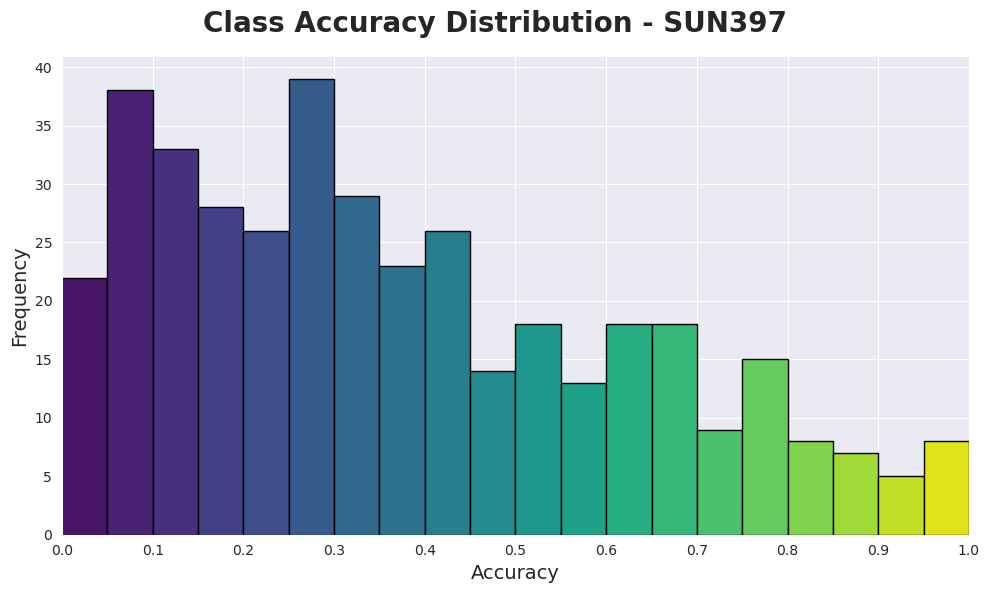

In [131]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [132]:
teacher_dtd_2 = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
get_model_params(teacher_dtd_2)

Parameters: 80.71M


In [134]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd_2,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 12/12 [00:00<00:00, 12.29it/s]


Epochs: 1/10 | train_loss: 4.5233 | train_acc: 0.0106


100%|██████████| 12/12 [00:00<00:00, 12.30it/s]


Epochs: 2/10 | train_loss: 2.9208 | train_acc: 0.2553


100%|██████████| 12/12 [00:00<00:00, 12.26it/s]


Epochs: 3/10 | train_loss: 1.8524 | train_acc: 0.7660


100%|██████████| 12/12 [00:00<00:00, 12.21it/s]


Epochs: 4/10 | train_loss: 1.1747 | train_acc: 0.9149


100%|██████████| 12/12 [00:00<00:00, 12.15it/s]


Epochs: 5/10 | train_loss: 0.8042 | train_acc: 0.9468


100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epochs: 6/10 | train_loss: 0.6970 | train_acc: 0.9468


100%|██████████| 12/12 [00:00<00:00, 12.20it/s]


Epochs: 7/10 | train_loss: 0.4556 | train_acc: 0.9787


100%|██████████| 12/12 [00:00<00:00, 12.24it/s]


Epochs: 8/10 | train_loss: 0.3430 | train_acc: 0.9894


100%|██████████| 12/12 [00:00<00:00, 12.17it/s]


Epochs: 9/10 | train_loss: 0.2807 | train_acc: 1.0000


100%|██████████| 12/12 [00:00<00:00, 12.18it/s]

Epochs: 10/10 | train_loss: 0.2500 | train_acc: 1.0000


In [135]:
deit_dtd_2 = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [136]:
get_model_params(deit_dtd_2)

Parameters: 85.87M


In [137]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd_2,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_dtd_2,
    few_shot=2
)

100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


Epochs: 1/10 | train_loss: 3.9681 | train_acc: 0.0213


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


Epochs: 2/10 | train_loss: 2.9412 | train_acc: 0.5319


100%|██████████| 12/12 [00:01<00:00,  6.76it/s]


Epochs: 3/10 | train_loss: 2.1389 | train_acc: 0.9149


100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


Epochs: 4/10 | train_loss: 1.4655 | train_acc: 0.9894


100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


Epochs: 5/10 | train_loss: 0.9921 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


Epochs: 6/10 | train_loss: 0.6646 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


Epochs: 7/10 | train_loss: 0.4649 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


Epochs: 8/10 | train_loss: 0.3369 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


Epochs: 9/10 | train_loss: 0.2559 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.74it/s]

Epochs: 10/10 | train_loss: 0.2018 | train_acc: 1.0000


In [138]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd_2,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:26<00:00,  8.76it/s]

test_loss: 2.7657 | test_acc: 0.3654


In [139]:
dtd_accs.append(dtd_acc)

In [140]:
get_top_5_accuracies(dtd_per_class_acc)

[('knitted', 0.925),
 ('cobwebbed', 0.85),
 ('paisley', 0.825),
 ('bubbly', 0.75),
 ('waffled', 0.75)]

In [141]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('gauzy', 0.0),
 ('zigzagged', 0.05),
 ('honeycombed', 0.075),
 ('stained', 0.075),
 ('braided', 0.1)]

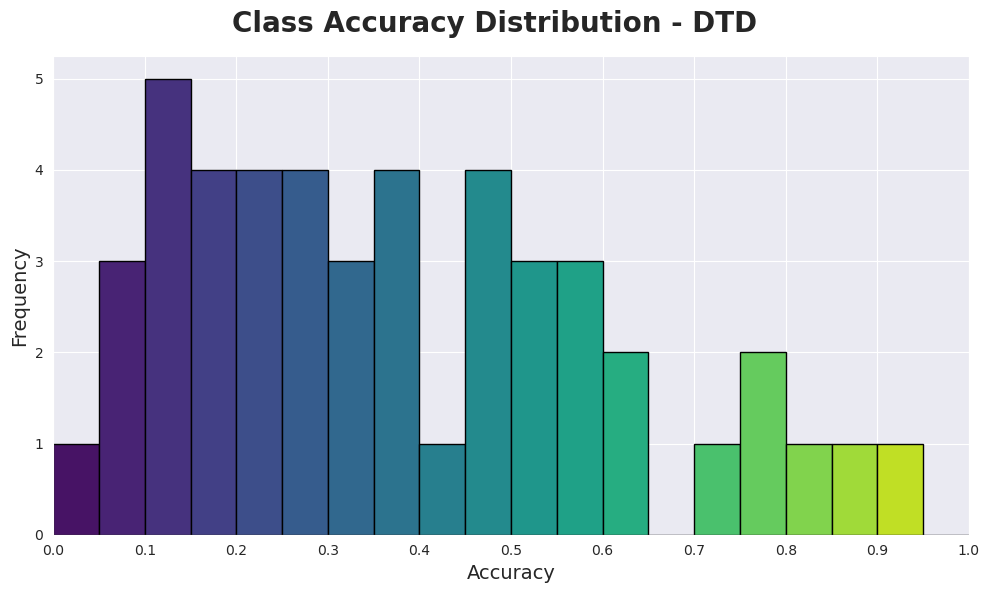

In [142]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=4)


Model is shown only 4 images per class from the dataset.

#### RESISC45

In [51]:
teacher_resisc45_4 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
get_model_params(teacher_resisc45_4)

Parameters: 80.70M


In [53]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45_4,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 23/23 [00:01<00:00, 14.90it/s]


Epochs: 1/10 | train_loss: 4.3612 | train_acc: 0.0333


100%|██████████| 23/23 [00:01<00:00, 20.18it/s]


Epochs: 2/10 | train_loss: 2.7505 | train_acc: 0.3556


100%|██████████| 23/23 [00:01<00:00, 20.28it/s]


Epochs: 3/10 | train_loss: 1.8576 | train_acc: 0.7056


100%|██████████| 23/23 [00:01<00:00, 20.45it/s]


Epochs: 4/10 | train_loss: 1.3222 | train_acc: 0.8722


100%|██████████| 23/23 [00:01<00:00, 20.14it/s]


Epochs: 5/10 | train_loss: 0.9784 | train_acc: 0.9111


100%|██████████| 23/23 [00:01<00:00, 20.64it/s]


Epochs: 6/10 | train_loss: 0.7381 | train_acc: 0.9444


100%|██████████| 23/23 [00:01<00:00, 20.38it/s]


Epochs: 7/10 | train_loss: 0.5701 | train_acc: 0.9778


100%|██████████| 23/23 [00:01<00:00, 20.04it/s]


Epochs: 8/10 | train_loss: 0.5128 | train_acc: 0.9500


100%|██████████| 23/23 [00:01<00:00, 20.07it/s]


Epochs: 9/10 | train_loss: 0.4235 | train_acc: 0.9722


100%|██████████| 23/23 [00:01<00:00, 20.17it/s]

Epochs: 10/10 | train_loss: 0.3163 | train_acc: 0.9889


In [54]:
deit_resisc45_4 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
get_model_params(deit_resisc45_4)

Parameters: 85.87M


In [56]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45_4,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_resisc45_4,
    few_shot=4
)

100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Epochs: 1/10 | train_loss: 3.8908 | train_acc: 0.0111


100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Epochs: 2/10 | train_loss: 2.5886 | train_acc: 0.6500


100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Epochs: 3/10 | train_loss: 1.7492 | train_acc: 0.9389


100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Epochs: 4/10 | train_loss: 1.1307 | train_acc: 0.9833


100%|██████████| 23/23 [00:02<00:00,  8.48it/s]


Epochs: 5/10 | train_loss: 0.7412 | train_acc: 0.9889


100%|██████████| 23/23 [00:02<00:00,  8.48it/s]


Epochs: 6/10 | train_loss: 0.5047 | train_acc: 1.0000


100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Epochs: 7/10 | train_loss: 0.3704 | train_acc: 1.0000


100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Epochs: 8/10 | train_loss: 0.2752 | train_acc: 1.0000


100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Epochs: 9/10 | train_loss: 0.2174 | train_acc: 1.0000


100%|██████████| 23/23 [00:02<00:00,  8.43it/s]

Epochs: 10/10 | train_loss: 0.1737 | train_acc: 1.0000


In [57]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45_4,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:08<00:00, 11.50it/s]

test_loss: 1.6913 | test_acc: 0.5941


In [58]:
resisc45_accs.append(resisc45_acc)

In [60]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9668874172185431),
 ('cloud', 0.89937106918239),
 ('beach', 0.8384615384615385),
 ('forest', 0.8287671232876712),
 ('circular farmland', 0.8013698630136986)]

In [61]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.1),
 ('basketball court', 0.19402985074626866),
 ('railway station', 0.2662337662337662),
 ('tennis court', 0.3680555555555556),
 ('ground track field', 0.3858267716535433)]

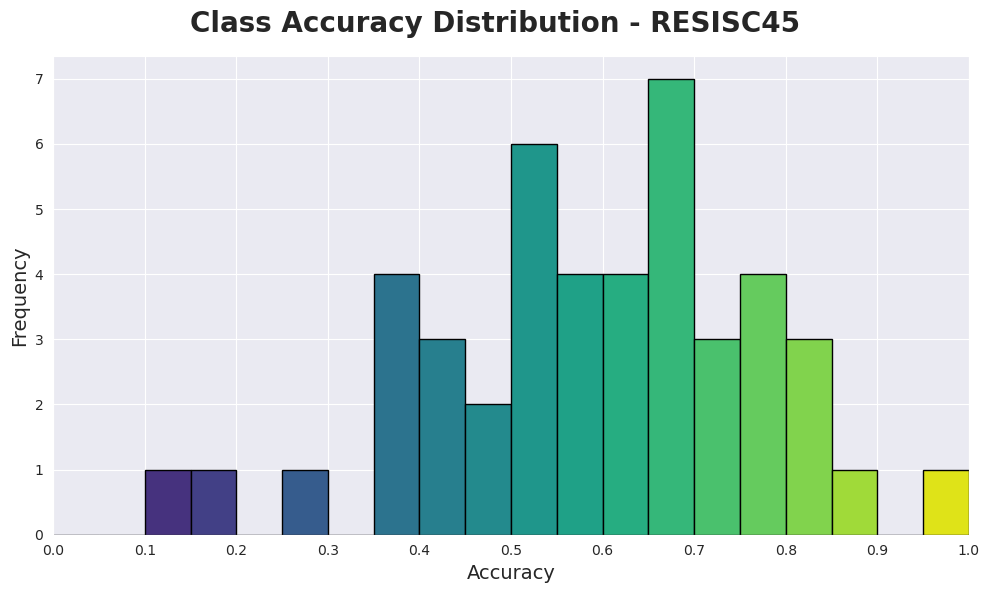

In [62]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [63]:
teacher_food101_4 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
get_model_params(teacher_food101_4)

Parameters: 80.87M


In [65]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101_4,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 51/51 [00:03<00:00, 13.32it/s]


Epochs: 1/10 | train_loss: 5.6207 | train_acc: 0.0050


100%|██████████| 51/51 [00:03<00:00, 13.46it/s]


Epochs: 2/10 | train_loss: 3.0515 | train_acc: 0.3837


100%|██████████| 51/51 [00:03<00:00, 13.32it/s]


Epochs: 3/10 | train_loss: 1.7740 | train_acc: 0.7574


100%|██████████| 51/51 [00:03<00:00, 13.30it/s]


Epochs: 4/10 | train_loss: 1.1020 | train_acc: 0.9035


100%|██████████| 51/51 [00:03<00:00, 13.37it/s]


Epochs: 5/10 | train_loss: 0.7193 | train_acc: 0.9653


100%|██████████| 51/51 [00:03<00:00, 13.13it/s]


Epochs: 6/10 | train_loss: 0.4577 | train_acc: 0.9901


100%|██████████| 51/51 [00:03<00:00, 13.36it/s]


Epochs: 7/10 | train_loss: 0.3185 | train_acc: 0.9926


100%|██████████| 51/51 [00:03<00:00, 13.19it/s]


Epochs: 8/10 | train_loss: 0.2667 | train_acc: 0.9926


100%|██████████| 51/51 [00:03<00:00, 13.22it/s]


Epochs: 9/10 | train_loss: 0.1943 | train_acc: 1.0000


100%|██████████| 51/51 [00:03<00:00, 13.26it/s]

Epochs: 10/10 | train_loss: 0.1521 | train_acc: 1.0000


In [66]:
deit_food101_4 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
get_model_params(deit_food101_4)

Parameters: 85.96M


In [68]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101_4,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_food101_4,
    few_shot=4
)

100%|██████████| 51/51 [00:07<00:00,  6.98it/s]


Epochs: 1/10 | train_loss: 4.6557 | train_acc: 0.0347


100%|██████████| 51/51 [00:07<00:00,  6.94it/s]


Epochs: 2/10 | train_loss: 3.1166 | train_acc: 0.6386


100%|██████████| 51/51 [00:07<00:00,  6.98it/s]


Epochs: 3/10 | train_loss: 2.0203 | train_acc: 0.9109


100%|██████████| 51/51 [00:07<00:00,  7.01it/s]


Epochs: 4/10 | train_loss: 1.2706 | train_acc: 0.9653


100%|██████████| 51/51 [00:07<00:00,  6.95it/s]


Epochs: 5/10 | train_loss: 0.8067 | train_acc: 0.9827


100%|██████████| 51/51 [00:07<00:00,  6.97it/s]


Epochs: 6/10 | train_loss: 0.5343 | train_acc: 0.9950


100%|██████████| 51/51 [00:07<00:00,  6.99it/s]


Epochs: 7/10 | train_loss: 0.3765 | train_acc: 0.9975


100%|██████████| 51/51 [00:07<00:00,  6.92it/s]


Epochs: 8/10 | train_loss: 0.2763 | train_acc: 0.9975


100%|██████████| 51/51 [00:07<00:00,  6.98it/s]


Epochs: 9/10 | train_loss: 0.2116 | train_acc: 0.9975


100%|██████████| 51/51 [00:07<00:00,  6.80it/s]

Epochs: 10/10 | train_loss: 0.1671 | train_acc: 1.0000


In [69]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101_4,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:51<00:00,  8.99it/s]


test_loss: 2.4324 | test_acc: 0.4259


In [70]:
food101_accs.append(food101_acc)

In [71]:
get_top_5_accuracies(food101_per_class_acc)

[('spaghetti carbonara', 0.956),
 ('guacamole', 0.94),
 ('edamame', 0.928),
 ('pizza', 0.912),
 ('pho', 0.884)]

In [72]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.048),
 ('nachos', 0.064),
 ('gnocchi', 0.136),
 ('lasagna', 0.14),
 ('ravioli', 0.14)]

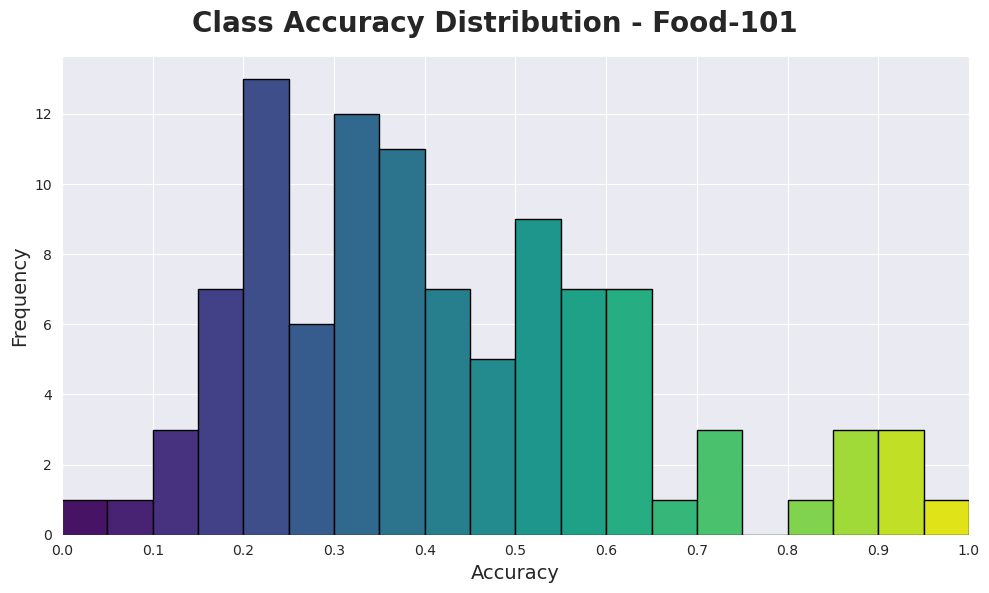

In [73]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [74]:
teacher_fer2013_4 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
get_model_params(teacher_fer2013_4)

Parameters: 80.59M


In [76]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013_4,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 4/4 [00:00<00:00, 21.43it/s]


Epochs: 1/10 | train_loss: 2.2294 | train_acc: 0.0714


100%|██████████| 4/4 [00:00<00:00, 21.48it/s]


Epochs: 2/10 | train_loss: 1.7523 | train_acc: 0.3571


100%|██████████| 4/4 [00:00<00:00, 21.30it/s]


Epochs: 3/10 | train_loss: 1.5558 | train_acc: 0.4643


100%|██████████| 4/4 [00:00<00:00, 20.76it/s]


Epochs: 4/10 | train_loss: 1.4068 | train_acc: 0.6429


100%|██████████| 4/4 [00:00<00:00, 20.94it/s]


Epochs: 5/10 | train_loss: 1.0500 | train_acc: 0.9643


100%|██████████| 4/4 [00:00<00:00, 21.39it/s]


Epochs: 6/10 | train_loss: 0.9901 | train_acc: 0.9286


100%|██████████| 4/4 [00:00<00:00, 22.01it/s]


Epochs: 7/10 | train_loss: 1.0008 | train_acc: 0.8929


100%|██████████| 4/4 [00:00<00:00, 21.67it/s]


Epochs: 8/10 | train_loss: 0.7213 | train_acc: 1.0000


100%|██████████| 4/4 [00:00<00:00, 21.11it/s]


Epochs: 9/10 | train_loss: 0.6507 | train_acc: 1.0000


100%|██████████| 4/4 [00:00<00:00, 21.60it/s]

Epochs: 10/10 | train_loss: 0.6351 | train_acc: 0.9643


In [77]:
deit_fer2013_4 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
get_model_params(deit_fer2013_4)

Parameters: 85.81M


In [79]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013_4,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_fer2013_4,
    few_shot=4
)

100%|██████████| 4/4 [00:00<00:00,  9.27it/s]


Epochs: 1/10 | train_loss: 2.1655 | train_acc: 0.1071


100%|██████████| 4/4 [00:00<00:00,  9.26it/s]


Epochs: 2/10 | train_loss: 1.8424 | train_acc: 0.2143


100%|██████████| 4/4 [00:00<00:00,  9.29it/s]


Epochs: 3/10 | train_loss: 1.6404 | train_acc: 0.3929


100%|██████████| 4/4 [00:00<00:00,  9.34it/s]


Epochs: 4/10 | train_loss: 1.5132 | train_acc: 0.5714


100%|██████████| 4/4 [00:00<00:00,  9.29it/s]


Epochs: 5/10 | train_loss: 1.4369 | train_acc: 0.6429


100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


Epochs: 6/10 | train_loss: 1.3061 | train_acc: 0.6786


100%|██████████| 4/4 [00:00<00:00,  9.28it/s]


Epochs: 7/10 | train_loss: 1.1930 | train_acc: 0.6786


100%|██████████| 4/4 [00:00<00:00,  9.21it/s]


Epochs: 8/10 | train_loss: 1.0852 | train_acc: 0.7143


100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


Epochs: 9/10 | train_loss: 0.9722 | train_acc: 0.8214


100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

Epochs: 10/10 | train_loss: 0.9484 | train_acc: 0.7857


In [80]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013_4,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:39<00:00, 11.28it/s]

test_loss: 2.0044 | test_acc: 0.1870


In [81]:
fer2013_accs.append(fer2013_acc)

In [82]:
fer2013_per_class_acc

{'angry': 0.18329938900203666,
 'disgust': 0.4727272727272727,
 'fear': 0.08901515151515152,
 'happy': 0.24800910125142206,
 'sad': 0.13131313131313133,
 'surprise': 0.1658653846153846,
 'neutral': 0.22843450479233227}

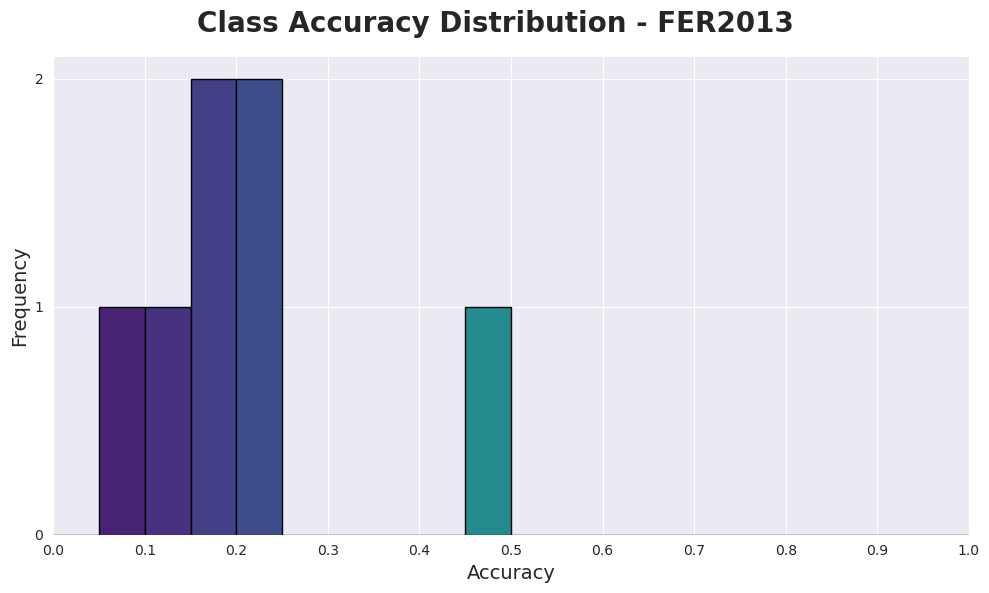

In [83]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [84]:
teacher_pcam_4 = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
get_model_params(teacher_pcam_4)

Parameters: 80.57M


In [86]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam_4,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epochs: 1/10 | train_loss: 0.6965 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epochs: 2/10 | train_loss: 0.5399 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epochs: 3/10 | train_loss: 0.4182 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epochs: 4/10 | train_loss: 0.3197 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epochs: 5/10 | train_loss: 0.2441 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


Epochs: 6/10 | train_loss: 0.1874 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epochs: 7/10 | train_loss: 0.1442 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epochs: 8/10 | train_loss: 0.1115 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epochs: 9/10 | train_loss: 0.0869 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 18.95it/s]

Epochs: 10/10 | train_loss: 0.0687 | train_acc: 1.0000


In [87]:
deit_pcam_4 = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
get_model_params(deit_pcam_4)

Parameters: 85.80M


In [89]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam_4,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True, 
    teacher=teacher_pcam_4,
    few_shot=4
)

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epochs: 1/10 | train_loss: 0.6525 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epochs: 2/10 | train_loss: 0.6017 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epochs: 3/10 | train_loss: 0.5654 | train_acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epochs: 4/10 | train_loss: 0.5347 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epochs: 5/10 | train_loss: 0.5052 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Epochs: 6/10 | train_loss: 0.4769 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epochs: 7/10 | train_loss: 0.4508 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epochs: 8/10 | train_loss: 0.4278 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epochs: 9/10 | train_loss: 0.4077 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

Epochs: 10/10 | train_loss: 0.3900 | train_acc: 0.7500


In [90]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam_4,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:05<00:00, 11.22it/s]

test_loss: 0.7295 | test_acc: 0.5404


In [91]:
pcam_accs.append(pcam_acc)

In [92]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.18290525288267953,
 'lymph node tumor tissue': 0.8981498442938267}

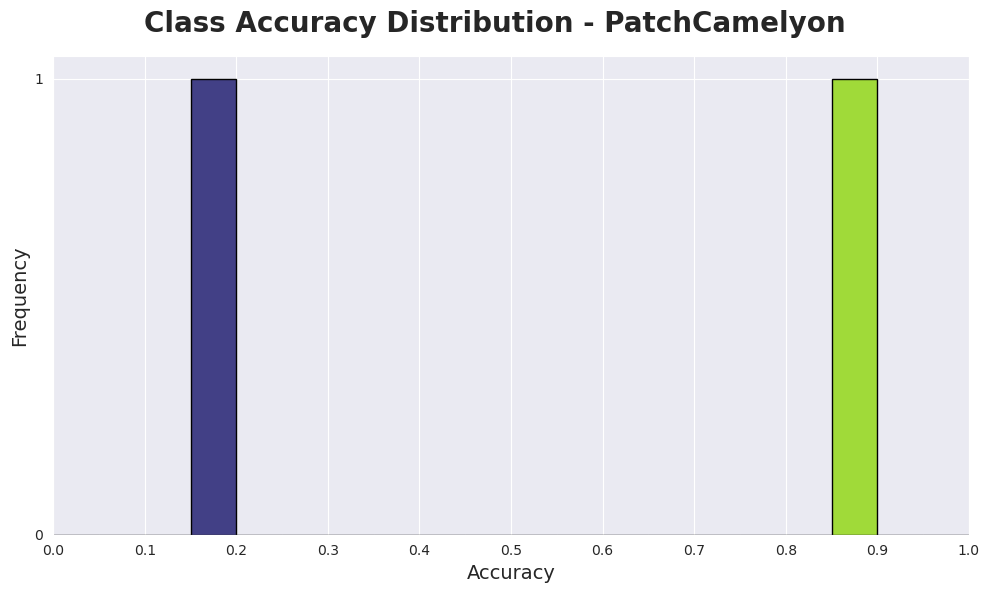

In [93]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [94]:
teacher_sun397_4 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
get_model_params(teacher_sun397_4)

Parameters: 81.77M


In [96]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397_4,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 199/199 [00:15<00:00, 12.61it/s]


Epochs: 1/10 | train_loss: 6.3203 | train_acc: 0.0334


100%|██████████| 199/199 [00:15<00:00, 12.54it/s]


Epochs: 2/10 | train_loss: 1.9209 | train_acc: 0.5856


100%|██████████| 199/199 [00:15<00:00, 13.02it/s]


Epochs: 3/10 | train_loss: 0.8224 | train_acc: 0.8514


100%|██████████| 199/199 [00:15<00:00, 13.02it/s]


Epochs: 4/10 | train_loss: 0.4382 | train_acc: 0.9433


100%|██████████| 199/199 [00:15<00:00, 13.00it/s]


Epochs: 5/10 | train_loss: 0.2618 | train_acc: 0.9698


100%|██████████| 199/199 [00:15<00:00, 13.00it/s]


Epochs: 6/10 | train_loss: 0.1828 | train_acc: 0.9849


100%|██████████| 199/199 [00:15<00:00, 13.00it/s]


Epochs: 7/10 | train_loss: 0.1278 | train_acc: 0.9887


100%|██████████| 199/199 [00:15<00:00, 12.96it/s]


Epochs: 8/10 | train_loss: 0.1157 | train_acc: 0.9893


100%|██████████| 199/199 [00:15<00:00, 13.01it/s]


Epochs: 9/10 | train_loss: 0.0848 | train_acc: 0.9956


100%|██████████| 199/199 [00:15<00:00, 12.63it/s]

Epochs: 10/10 | train_loss: 0.0878 | train_acc: 0.9931


In [97]:
deit_sun397_4 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
get_model_params(deit_sun397_4)

Parameters: 86.41M


In [99]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397_4,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_sun397_4,
    few_shot=4
)

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Epochs: 1/10 | train_loss: 5.7506 | train_acc: 0.0617


100%|██████████| 199/199 [00:28<00:00,  6.87it/s]


Epochs: 2/10 | train_loss: 2.6097 | train_acc: 0.7683


100%|██████████| 199/199 [00:28<00:00,  6.87it/s]


Epochs: 3/10 | train_loss: 0.9051 | train_acc: 0.9547


100%|██████████| 199/199 [00:29<00:00,  6.86it/s]


Epochs: 4/10 | train_loss: 0.3569 | train_acc: 0.9912


100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Epochs: 5/10 | train_loss: 0.1830 | train_acc: 0.9981


100%|██████████| 199/199 [00:29<00:00,  6.86it/s]


Epochs: 6/10 | train_loss: 0.1128 | train_acc: 0.9987


100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Epochs: 7/10 | train_loss: 0.0779 | train_acc: 0.9987


100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Epochs: 8/10 | train_loss: 0.0580 | train_acc: 0.9987


100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Epochs: 9/10 | train_loss: 0.0451 | train_acc: 0.9994


100%|██████████| 199/199 [00:28<00:00,  6.87it/s]

Epochs: 10/10 | train_loss: 0.0362 | train_acc: 1.0000


In [100]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397_4,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:10<00:00,  8.75it/s]


test_loss: 2.2416 | test_acc: 0.4700


In [101]:
sun397_accs.append(sun397_acc)

In [102]:
get_top_5_accuracies(sun397_per_class_acc)

[('volcano', 1.0),
 ('underwater (coral reef)', 0.9913793103448276),
 ('tent (outdoor)', 0.975),
 ('oilrig', 0.9666666666666667),
 ('dam', 0.9629629629629629)]

In [103]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bazaar (outdoor)', 0.0),
 ('rice paddy', 0.0),
 ('museum (indoor)', 0.03508771929824561),
 ('ticket booth', 0.03571428571428571),
 ('building facade', 0.05555555555555555)]

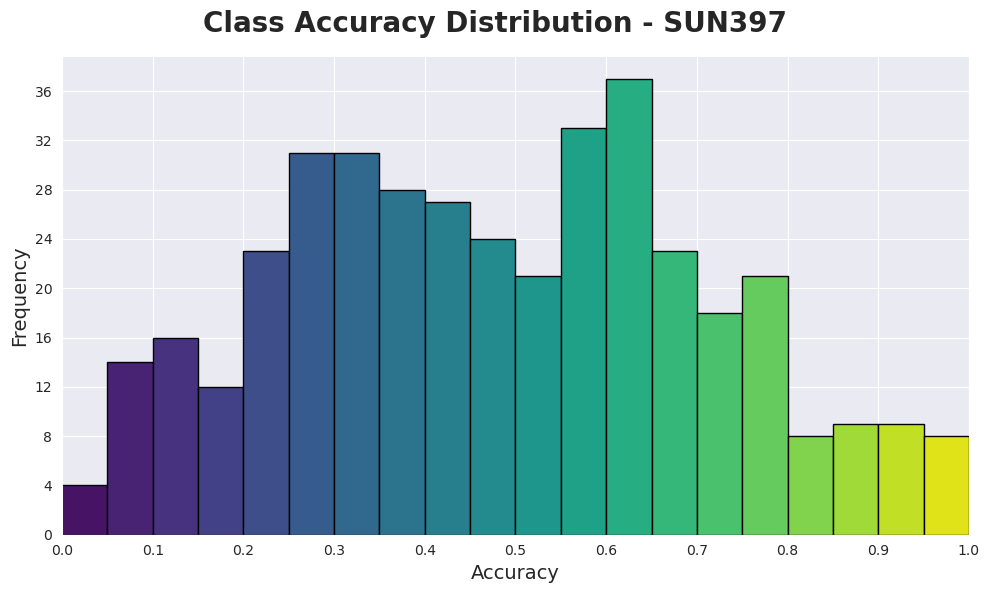

In [104]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [105]:
teacher_dtd_4 = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
get_model_params(teacher_dtd_4)

Parameters: 80.71M


In [107]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd_4,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 24/24 [00:01<00:00, 12.27it/s]


Epochs: 1/10 | train_loss: 4.4192 | train_acc: 0.0266


100%|██████████| 24/24 [00:01<00:00, 12.25it/s]


Epochs: 2/10 | train_loss: 2.4646 | train_acc: 0.4362


100%|██████████| 24/24 [00:01<00:00, 12.23it/s]


Epochs: 3/10 | train_loss: 1.6591 | train_acc: 0.6755


100%|██████████| 24/24 [00:01<00:00, 12.35it/s]


Epochs: 4/10 | train_loss: 1.3026 | train_acc: 0.7872


100%|██████████| 24/24 [00:01<00:00, 12.34it/s]


Epochs: 5/10 | train_loss: 0.9896 | train_acc: 0.8191


100%|██████████| 24/24 [00:01<00:00, 12.27it/s]


Epochs: 6/10 | train_loss: 0.8174 | train_acc: 0.8777


100%|██████████| 24/24 [00:01<00:00, 12.28it/s]


Epochs: 7/10 | train_loss: 0.6494 | train_acc: 0.8936


100%|██████████| 24/24 [00:01<00:00, 12.25it/s]


Epochs: 8/10 | train_loss: 0.5328 | train_acc: 0.9202


100%|██████████| 24/24 [00:01<00:00, 12.29it/s]


Epochs: 9/10 | train_loss: 0.5490 | train_acc: 0.8883


100%|██████████| 24/24 [00:01<00:00, 12.27it/s]

Epochs: 10/10 | train_loss: 0.3543 | train_acc: 0.9681


In [108]:
deit_dtd_4 = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
get_model_params(deit_dtd_4)

Parameters: 85.87M


In [110]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd_4,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_dtd_4,
    few_shot=4
)

100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Epochs: 1/10 | train_loss: 3.8940 | train_acc: 0.0532


100%|██████████| 24/24 [00:03<00:00,  6.68it/s]


Epochs: 2/10 | train_loss: 2.6780 | train_acc: 0.6383


100%|██████████| 24/24 [00:03<00:00,  6.68it/s]


Epochs: 3/10 | train_loss: 1.8102 | train_acc: 0.9096


100%|██████████| 24/24 [00:03<00:00,  6.67it/s]


Epochs: 4/10 | train_loss: 1.1909 | train_acc: 0.9574


100%|██████████| 24/24 [00:03<00:00,  6.67it/s]


Epochs: 5/10 | train_loss: 0.7978 | train_acc: 0.9734


100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Epochs: 6/10 | train_loss: 0.5493 | train_acc: 0.9787


100%|██████████| 24/24 [00:03<00:00,  6.65it/s]


Epochs: 7/10 | train_loss: 0.3968 | train_acc: 0.9840


100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Epochs: 8/10 | train_loss: 0.3039 | train_acc: 0.9894


100%|██████████| 24/24 [00:03<00:00,  6.71it/s]


Epochs: 9/10 | train_loss: 0.2489 | train_acc: 0.9894


100%|██████████| 24/24 [00:03<00:00,  6.62it/s]

Epochs: 10/10 | train_loss: 0.1991 | train_acc: 0.9947


In [111]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd_4,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:26<00:00,  8.79it/s]

test_loss: 2.3058 | test_acc: 0.4660


In [112]:
dtd_accs.append(dtd_acc)

In [113]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.925),
 ('bubbly', 0.85),
 ('knitted', 0.85),
 ('chequered', 0.775),
 ('frilly', 0.75)]

In [114]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('gauzy', 0.05),
 ('blotchy', 0.15),
 ('flecked', 0.15),
 ('porous', 0.15),
 ('stained', 0.15)]

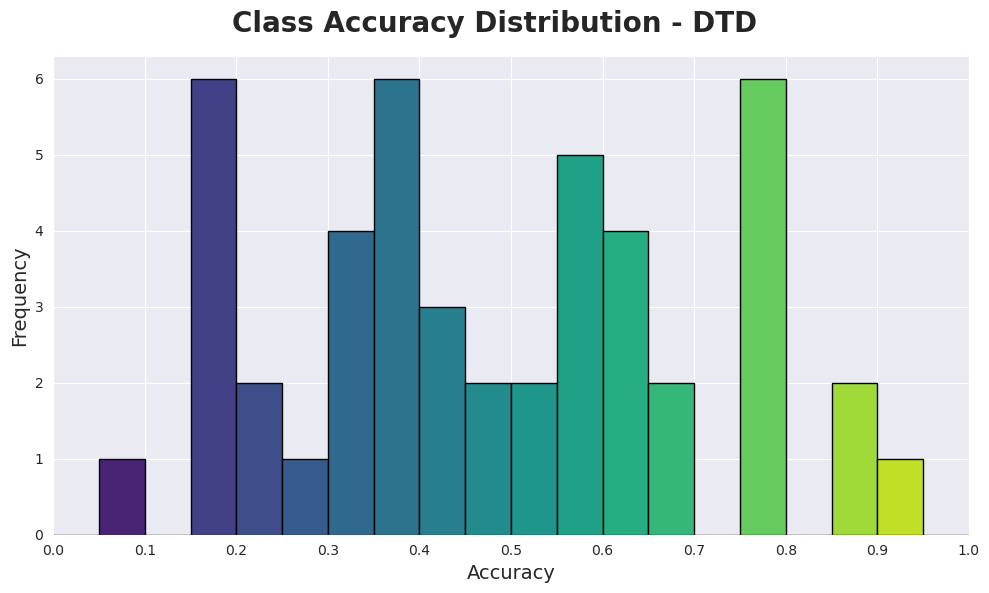

In [115]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=8)


Model is shown only 8 images per class from the dataset.

#### RESISC45

In [116]:
teacher_resisc45_8 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:
get_model_params(teacher_resisc45_8)

Parameters: 80.70M


In [118]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45_8,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 45/45 [00:02<00:00, 19.69it/s]


Epochs: 1/10 | train_loss: 4.0731 | train_acc: 0.0639


100%|██████████| 45/45 [00:02<00:00, 20.12it/s]


Epochs: 2/10 | train_loss: 2.3673 | train_acc: 0.4500


100%|██████████| 45/45 [00:02<00:00, 20.06it/s]


Epochs: 3/10 | train_loss: 1.6862 | train_acc: 0.6361


100%|██████████| 45/45 [00:02<00:00, 19.48it/s]


Epochs: 4/10 | train_loss: 1.2235 | train_acc: 0.7694


100%|██████████| 45/45 [00:02<00:00, 19.49it/s]


Epochs: 5/10 | train_loss: 0.8755 | train_acc: 0.8611


100%|██████████| 45/45 [00:02<00:00, 19.86it/s]


Epochs: 6/10 | train_loss: 0.7536 | train_acc: 0.8972


100%|██████████| 45/45 [00:02<00:00, 19.79it/s]


Epochs: 7/10 | train_loss: 0.5454 | train_acc: 0.9444


100%|██████████| 45/45 [00:02<00:00, 20.01it/s]


Epochs: 8/10 | train_loss: 0.4840 | train_acc: 0.9389


100%|██████████| 45/45 [00:02<00:00, 19.84it/s]


Epochs: 9/10 | train_loss: 0.4256 | train_acc: 0.9611


100%|██████████| 45/45 [00:02<00:00, 19.85it/s]

Epochs: 10/10 | train_loss: 0.3426 | train_acc: 0.9528


In [119]:
deit_resisc45_8 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
get_model_params(deit_resisc45_8)

Parameters: 85.87M


In [121]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45_8,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_resisc45_8,
    few_shot=8
)

100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Epochs: 1/10 | train_loss: 3.5765 | train_acc: 0.1361


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Epochs: 2/10 | train_loss: 2.0185 | train_acc: 0.7556


100%|██████████| 45/45 [00:05<00:00,  8.39it/s]


Epochs: 3/10 | train_loss: 1.2118 | train_acc: 0.9222


100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


Epochs: 4/10 | train_loss: 0.7778 | train_acc: 0.9639


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Epochs: 5/10 | train_loss: 0.5278 | train_acc: 0.9833


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Epochs: 6/10 | train_loss: 0.3806 | train_acc: 0.9889


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Epochs: 7/10 | train_loss: 0.2837 | train_acc: 1.0000


100%|██████████| 45/45 [00:05<00:00,  8.15it/s]


Epochs: 8/10 | train_loss: 0.2228 | train_acc: 1.0000


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Epochs: 9/10 | train_loss: 0.1761 | train_acc: 1.0000


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]

Epochs: 10/10 | train_loss: 0.1445 | train_acc: 1.0000


In [122]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45_8,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:08<00:00, 11.52it/s]

test_loss: 1.2165 | test_acc: 0.6892


In [123]:
resisc45_accs.append(resisc45_acc)

In [124]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9337748344370861),
 ('beach', 0.8846153846153846),
 ('cloud', 0.8742138364779874),
 ('rectangular farmland', 0.8592592592592593),
 ('circular farmland', 0.8561643835616438)]

In [125]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.38571428571428573),
 ('basketball court', 0.44029850746268656),
 ('tennis court', 0.4583333333333333),
 ('railway', 0.4642857142857143),
 ('overpass', 0.4866666666666667)]

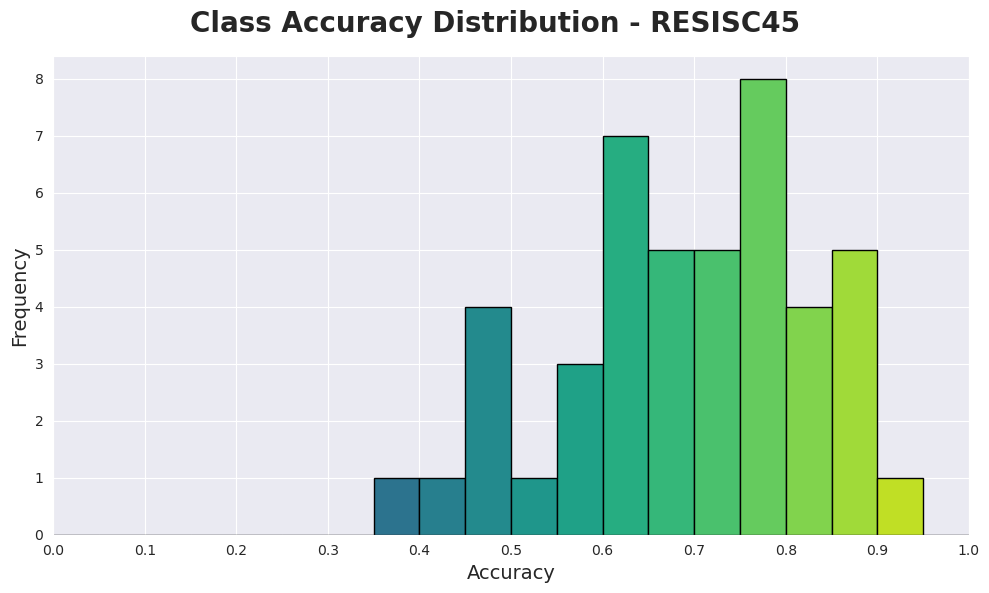

In [126]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [127]:
teacher_food101_8 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
get_model_params(teacher_food101_8)

Parameters: 80.87M


In [129]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101_8,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 101/101 [00:07<00:00, 13.39it/s]


Epochs: 1/10 | train_loss: 5.0484 | train_acc: 0.0347


100%|██████████| 101/101 [00:07<00:00, 13.42it/s]


Epochs: 2/10 | train_loss: 2.8077 | train_acc: 0.4097


100%|██████████| 101/101 [00:07<00:00, 13.42it/s]


Epochs: 3/10 | train_loss: 1.7797 | train_acc: 0.6646


100%|██████████| 101/101 [00:07<00:00, 13.21it/s]


Epochs: 4/10 | train_loss: 1.1801 | train_acc: 0.8342


100%|██████████| 101/101 [00:08<00:00, 12.59it/s]


Epochs: 5/10 | train_loss: 0.7964 | train_acc: 0.9146


100%|██████████| 101/101 [00:07<00:00, 13.41it/s]


Epochs: 6/10 | train_loss: 0.5226 | train_acc: 0.9629


100%|██████████| 101/101 [00:07<00:00, 13.43it/s]


Epochs: 7/10 | train_loss: 0.4148 | train_acc: 0.9777


100%|██████████| 101/101 [00:07<00:00, 13.45it/s]


Epochs: 8/10 | train_loss: 0.3160 | train_acc: 0.9901


100%|██████████| 101/101 [00:07<00:00, 13.42it/s]


Epochs: 9/10 | train_loss: 0.2294 | train_acc: 0.9913


100%|██████████| 101/101 [00:07<00:00, 13.46it/s]

Epochs: 10/10 | train_loss: 0.2310 | train_acc: 0.9851


In [130]:
deit_food101_8 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
get_model_params(deit_food101_8)

Parameters: 85.96M


In [132]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101_8,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_food101_8,
    few_shot=8
)

100%|██████████| 101/101 [00:14<00:00,  6.77it/s]


Epochs: 1/10 | train_loss: 4.3522 | train_acc: 0.1077


100%|██████████| 101/101 [00:14<00:00,  6.89it/s]


Epochs: 2/10 | train_loss: 2.5598 | train_acc: 0.6782


100%|██████████| 101/101 [00:14<00:00,  6.91it/s]


Epochs: 3/10 | train_loss: 1.5383 | train_acc: 0.8527


100%|██████████| 101/101 [00:14<00:00,  6.87it/s]


Epochs: 4/10 | train_loss: 0.9652 | train_acc: 0.9381


100%|██████████| 101/101 [00:14<00:00,  6.89it/s]


Epochs: 5/10 | train_loss: 0.6422 | train_acc: 0.9653


100%|██████████| 101/101 [00:14<00:00,  6.86it/s]


Epochs: 6/10 | train_loss: 0.4469 | train_acc: 0.9839


100%|██████████| 101/101 [00:14<00:00,  6.87it/s]


Epochs: 7/10 | train_loss: 0.3226 | train_acc: 0.9938


100%|██████████| 101/101 [00:14<00:00,  6.86it/s]


Epochs: 8/10 | train_loss: 0.2409 | train_acc: 0.9988


100%|██████████| 101/101 [00:14<00:00,  6.78it/s]


Epochs: 9/10 | train_loss: 0.1870 | train_acc: 0.9988


100%|██████████| 101/101 [00:14<00:00,  6.88it/s]

Epochs: 10/10 | train_loss: 0.1487 | train_acc: 1.0000


In [133]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101_8,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:56<00:00,  8.86it/s]


test_loss: 1.8995 | test_acc: 0.5209


In [134]:
food101_accs.append(food101_acc)

In [135]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.968),
 ('spaghetti carbonara', 0.964),
 ('guacamole', 0.928),
 ('pizza', 0.904),
 ('pho', 0.876)]

In [136]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.136),
 ('ravioli', 0.152),
 ('scallops', 0.184),
 ('grilled salmon', 0.22),
 ('lasagna', 0.244)]

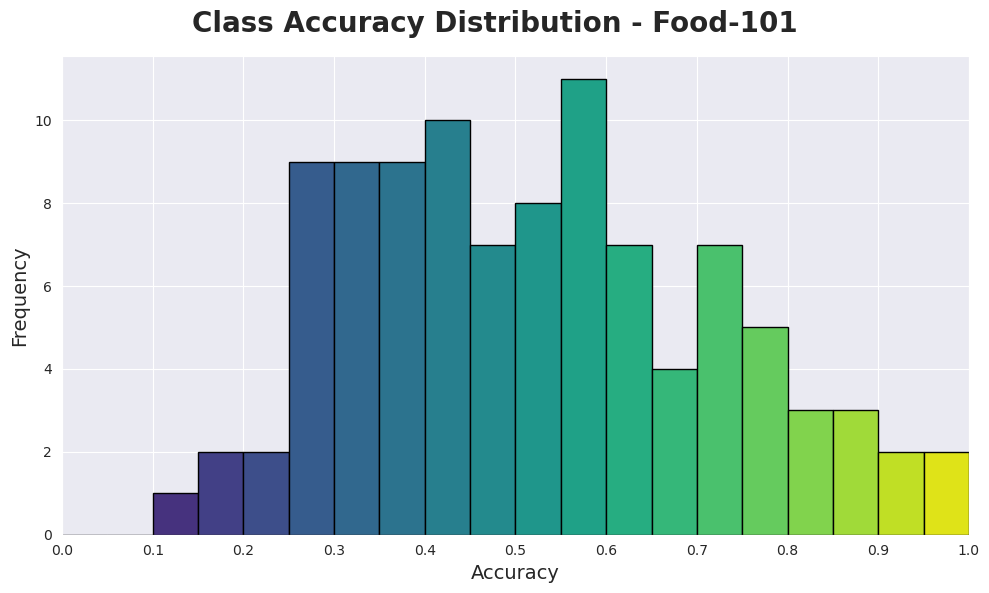

In [137]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [138]:
teacher_fer2013_8 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
get_model_params(teacher_fer2013_8)

Parameters: 80.59M


In [140]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013_8,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 7/7 [00:00<00:00, 19.04it/s]


Epochs: 1/10 | train_loss: 2.2448 | train_acc: 0.1071


100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


Epochs: 2/10 | train_loss: 1.9392 | train_acc: 0.1964


100%|██████████| 7/7 [00:00<00:00, 19.12it/s]


Epochs: 3/10 | train_loss: 1.7011 | train_acc: 0.4643


100%|██████████| 7/7 [00:00<00:00, 19.26it/s]


Epochs: 4/10 | train_loss: 1.4579 | train_acc: 0.6071


100%|██████████| 7/7 [00:00<00:00, 19.50it/s]


Epochs: 5/10 | train_loss: 1.3236 | train_acc: 0.7857


100%|██████████| 7/7 [00:00<00:00, 19.34it/s]


Epochs: 6/10 | train_loss: 1.0992 | train_acc: 0.8571


100%|██████████| 7/7 [00:00<00:00, 18.64it/s]


Epochs: 7/10 | train_loss: 1.0611 | train_acc: 0.8929


100%|██████████| 7/7 [00:00<00:00, 19.51it/s]


Epochs: 8/10 | train_loss: 0.8903 | train_acc: 0.9464


100%|██████████| 7/7 [00:00<00:00, 18.93it/s]


Epochs: 9/10 | train_loss: 0.8173 | train_acc: 0.9286


100%|██████████| 7/7 [00:00<00:00, 19.12it/s]

Epochs: 10/10 | train_loss: 0.7793 | train_acc: 0.9821


In [141]:
deit_fer2013_8 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [142]:
get_model_params(deit_fer2013_8)

Parameters: 85.81M


In [143]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013_8,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_fer2013_8,
    few_shot=8
)

100%|██████████| 7/7 [00:00<00:00,  8.18it/s]


Epochs: 1/10 | train_loss: 1.9598 | train_acc: 0.1250


100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


Epochs: 2/10 | train_loss: 1.7103 | train_acc: 0.1786


100%|██████████| 7/7 [00:00<00:00,  8.22it/s]


Epochs: 3/10 | train_loss: 1.5537 | train_acc: 0.3036


100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


Epochs: 4/10 | train_loss: 1.4227 | train_acc: 0.5000


100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epochs: 5/10 | train_loss: 1.2963 | train_acc: 0.6429


100%|██████████| 7/7 [00:00<00:00,  8.22it/s]


Epochs: 6/10 | train_loss: 1.2067 | train_acc: 0.6429


100%|██████████| 7/7 [00:00<00:00,  8.19it/s]


Epochs: 7/10 | train_loss: 1.1187 | train_acc: 0.6786


100%|██████████| 7/7 [00:00<00:00,  8.26it/s]


Epochs: 8/10 | train_loss: 1.0444 | train_acc: 0.6786


100%|██████████| 7/7 [00:00<00:00,  8.22it/s]


Epochs: 9/10 | train_loss: 0.9768 | train_acc: 0.6786


100%|██████████| 7/7 [00:00<00:00,  8.21it/s]

Epochs: 10/10 | train_loss: 0.9214 | train_acc: 0.6786


In [144]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013_8,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:39<00:00, 11.32it/s]

test_loss: 2.1360 | test_acc: 0.1605


In [145]:
fer2013_accs.append(fer2013_acc)

In [146]:
fer2013_per_class_acc

{'angry': 0.07942973523421588,
 'disgust': 0.6545454545454545,
 'fear': 0.1875,
 'happy': 0.19340159271899887,
 'sad': 0.030303030303030304,
 'surprise': 0.37740384615384615,
 'neutral': 0.09105431309904154}

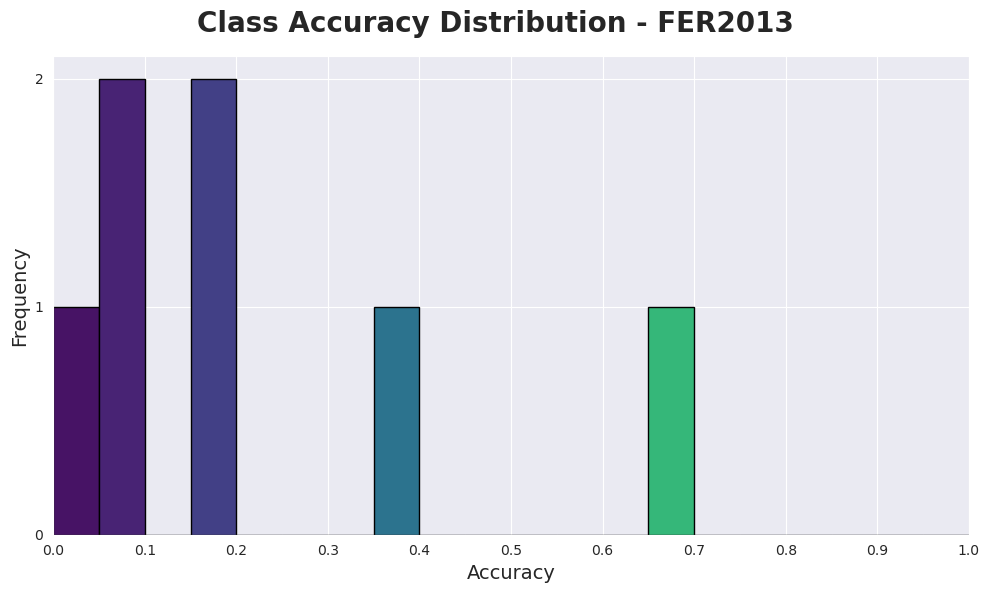

In [147]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [148]:
teacher_pcam_8 = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [149]:
get_model_params(teacher_pcam_8)

Parameters: 80.57M


In [150]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam_8,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 2/2 [00:00<00:00, 17.90it/s]


Epochs: 1/10 | train_loss: 0.7928 | train_acc: 0.6250


100%|██████████| 2/2 [00:00<00:00, 18.78it/s]


Epochs: 2/10 | train_loss: 0.7393 | train_acc: 0.5000


100%|██████████| 2/2 [00:00<00:00, 18.36it/s]


Epochs: 3/10 | train_loss: 0.6107 | train_acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 17.98it/s]


Epochs: 4/10 | train_loss: 0.5351 | train_acc: 0.7500


100%|██████████| 2/2 [00:00<00:00, 18.67it/s]


Epochs: 5/10 | train_loss: 0.4671 | train_acc: 0.8750


100%|██████████| 2/2 [00:00<00:00, 18.91it/s]


Epochs: 6/10 | train_loss: 0.5547 | train_acc: 0.7500


100%|██████████| 2/2 [00:00<00:00, 18.88it/s]


Epochs: 7/10 | train_loss: 0.4271 | train_acc: 0.9375


100%|██████████| 2/2 [00:00<00:00, 18.82it/s]


Epochs: 8/10 | train_loss: 0.3532 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 17.95it/s]


Epochs: 9/10 | train_loss: 0.3573 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 18.56it/s]

Epochs: 10/10 | train_loss: 0.4140 | train_acc: 0.9375


In [151]:
deit_pcam_8 = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [152]:
get_model_params(deit_pcam_8)

Parameters: 85.80M


In [153]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam_8,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True, 
    teacher=teacher_pcam_8,
    few_shot=8
)

100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epochs: 1/10 | train_loss: 0.8013 | train_acc: 0.3750


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Epochs: 2/10 | train_loss: 0.6924 | train_acc: 0.3750


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epochs: 3/10 | train_loss: 0.6266 | train_acc: 0.6250


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Epochs: 4/10 | train_loss: 0.5787 | train_acc: 0.6875


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epochs: 5/10 | train_loss: 0.5290 | train_acc: 0.7500


100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


Epochs: 6/10 | train_loss: 0.4885 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epochs: 7/10 | train_loss: 0.4513 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epochs: 8/10 | train_loss: 0.4206 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epochs: 9/10 | train_loss: 0.3973 | train_acc: 0.8750


100%|██████████| 2/2 [00:00<00:00,  8.16it/s]

Epochs: 10/10 | train_loss: 0.3729 | train_acc: 0.8750


In [154]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam_8,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:05<00:00, 11.21it/s]

test_loss: 0.5759 | test_acc: 0.7187


In [155]:
pcam_accs.append(pcam_acc)

In [156]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.6782990665609175,
 'lymph node tumor tissue': 0.7591133907309031}

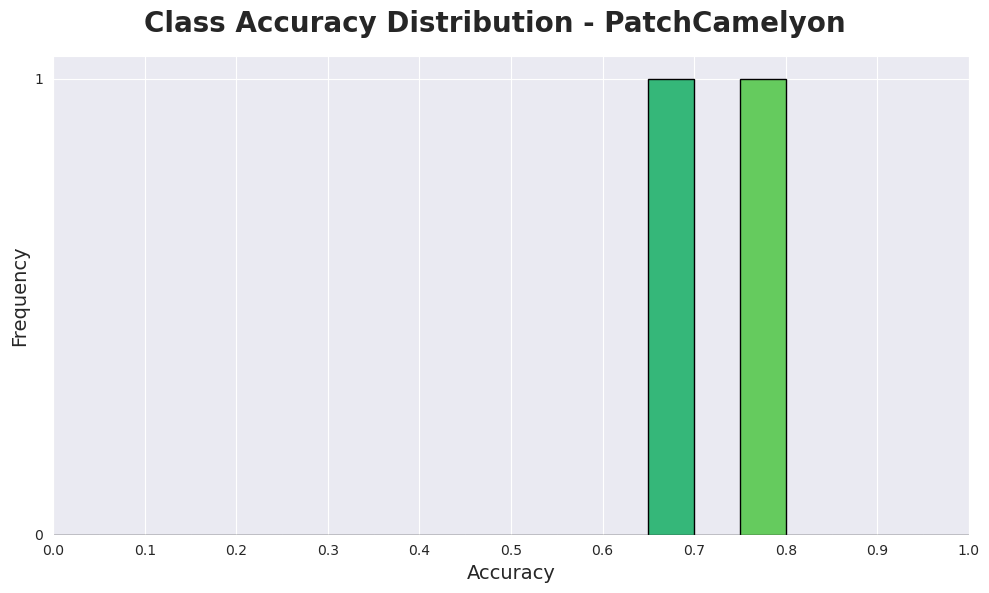

In [157]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [158]:
teacher_sun397_8 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [159]:
get_model_params(teacher_sun397_8)

Parameters: 81.77M


In [160]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397_8,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 397/397 [00:30<00:00, 12.84it/s]


Epochs: 1/10 | train_loss: 5.3045 | train_acc: 0.0897


100%|██████████| 397/397 [00:30<00:00, 13.01it/s]


Epochs: 2/10 | train_loss: 1.8640 | train_acc: 0.5397


100%|██████████| 397/397 [00:30<00:00, 13.01it/s]


Epochs: 3/10 | train_loss: 0.9926 | train_acc: 0.7535


100%|██████████| 397/397 [00:30<00:00, 12.96it/s]


Epochs: 4/10 | train_loss: 0.6315 | train_acc: 0.8545


100%|██████████| 397/397 [00:30<00:00, 13.02it/s]


Epochs: 5/10 | train_loss: 0.4229 | train_acc: 0.9052


100%|██████████| 397/397 [00:30<00:00, 13.00it/s]


Epochs: 6/10 | train_loss: 0.3170 | train_acc: 0.9377


100%|██████████| 397/397 [00:30<00:00, 13.02it/s]


Epochs: 7/10 | train_loss: 0.2534 | train_acc: 0.9465


100%|██████████| 397/397 [00:30<00:00, 13.02it/s]


Epochs: 8/10 | train_loss: 0.2178 | train_acc: 0.9518


100%|██████████| 397/397 [00:30<00:00, 13.01it/s]


Epochs: 9/10 | train_loss: 0.1870 | train_acc: 0.9578


100%|██████████| 397/397 [00:31<00:00, 12.78it/s]

Epochs: 10/10 | train_loss: 0.1788 | train_acc: 0.9581


In [161]:
deit_sun397_8 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [162]:
get_model_params(deit_sun397_8)

Parameters: 86.41M


In [163]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397_8,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_sun397_8,
    few_shot=8
)

100%|██████████| 397/397 [00:59<00:00,  6.70it/s]


Epochs: 1/10 | train_loss: 4.7946 | train_acc: 0.1977


100%|██████████| 397/397 [00:58<00:00,  6.80it/s]


Epochs: 2/10 | train_loss: 1.5244 | train_acc: 0.7755


100%|██████████| 397/397 [00:57<00:00,  6.85it/s]


Epochs: 3/10 | train_loss: 0.5548 | train_acc: 0.9323


100%|██████████| 397/397 [00:58<00:00,  6.82it/s]


Epochs: 4/10 | train_loss: 0.2618 | train_acc: 0.9808


100%|██████████| 397/397 [00:58<00:00,  6.84it/s]


Epochs: 5/10 | train_loss: 0.1475 | train_acc: 0.9921


100%|██████████| 397/397 [00:58<00:00,  6.80it/s]


Epochs: 6/10 | train_loss: 0.0973 | train_acc: 0.9928


100%|██████████| 397/397 [00:58<00:00,  6.84it/s]


Epochs: 7/10 | train_loss: 0.0725 | train_acc: 0.9934


100%|██████████| 397/397 [00:58<00:00,  6.80it/s]


Epochs: 8/10 | train_loss: 0.0587 | train_acc: 0.9934


100%|██████████| 397/397 [00:58<00:00,  6.81it/s]


Epochs: 9/10 | train_loss: 0.0514 | train_acc: 0.9940


100%|██████████| 397/397 [00:58<00:00,  6.83it/s]

Epochs: 10/10 | train_loss: 0.0452 | train_acc: 0.9928


In [164]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397_8,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:10<00:00,  8.77it/s]


test_loss: 1.8025 | test_acc: 0.5415


In [165]:
sun397_accs.append(sun397_acc)

In [166]:
get_top_5_accuracies(sun397_per_class_acc)

[('dam', 1.0),
 ('oilrig', 1.0),
 ('underwater (coral reef)', 1.0),
 ('volcano', 1.0),
 ('raft', 0.9787234042553191)]

In [167]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('museum (indoor)', 0.03508771929824561),
 ('biology laboratory', 0.045454545454545456),
 ('assembly line', 0.06060606060606061),
 ('inn (outdoor)', 0.06896551724137931),
 ('gift shop', 0.07142857142857142)]

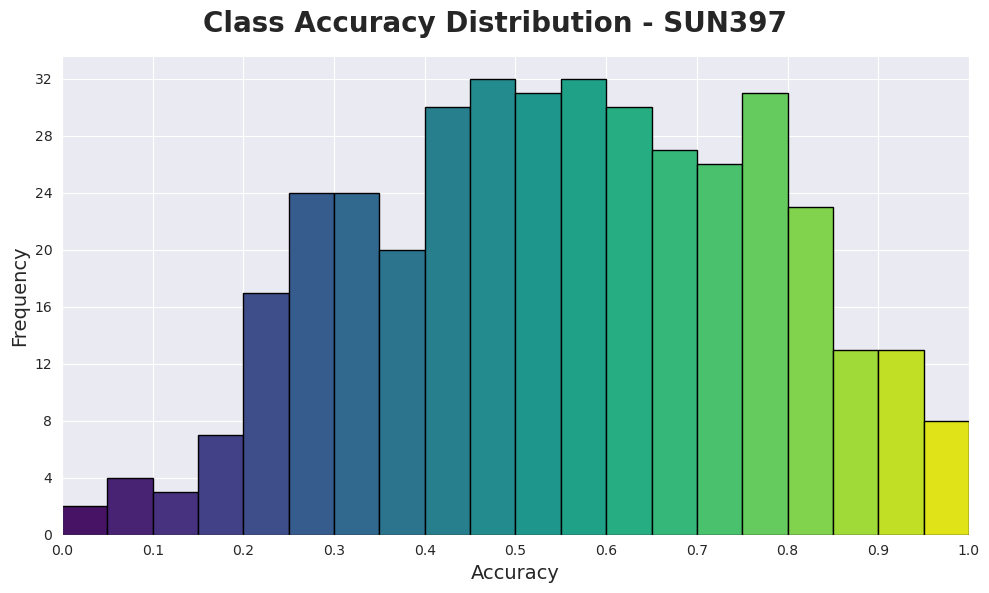

In [168]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [169]:
teacher_dtd_8 = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [170]:
get_model_params(teacher_dtd_8)

Parameters: 80.71M


In [171]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd_8,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 47/47 [00:03<00:00, 12.11it/s]


Epochs: 1/10 | train_loss: 3.8497 | train_acc: 0.1064


100%|██████████| 47/47 [00:03<00:00, 12.04it/s]


Epochs: 2/10 | train_loss: 2.0040 | train_acc: 0.5133


100%|██████████| 47/47 [00:03<00:00, 12.01it/s]


Epochs: 3/10 | train_loss: 1.4094 | train_acc: 0.6489


100%|██████████| 47/47 [00:03<00:00, 12.00it/s]


Epochs: 4/10 | train_loss: 1.1604 | train_acc: 0.7154


100%|██████████| 47/47 [00:03<00:00, 11.93it/s]


Epochs: 5/10 | train_loss: 0.9199 | train_acc: 0.7979


100%|██████████| 47/47 [00:03<00:00, 11.94it/s]


Epochs: 6/10 | train_loss: 0.7630 | train_acc: 0.8271


100%|██████████| 47/47 [00:04<00:00, 10.52it/s]


Epochs: 7/10 | train_loss: 0.6639 | train_acc: 0.8378


100%|██████████| 47/47 [00:04<00:00, 11.67it/s]


Epochs: 8/10 | train_loss: 0.6152 | train_acc: 0.8617


100%|██████████| 47/47 [00:03<00:00, 11.98it/s]


Epochs: 9/10 | train_loss: 0.5136 | train_acc: 0.8830


100%|██████████| 47/47 [00:03<00:00, 11.99it/s]

Epochs: 10/10 | train_loss: 0.4765 | train_acc: 0.8830


In [172]:
deit_dtd_8 = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
get_model_params(deit_dtd_8)

Parameters: 85.87M


In [174]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd_8,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_dtd_8,
    few_shot=8
)

100%|██████████| 47/47 [00:07<00:00,  6.62it/s]


Epochs: 1/10 | train_loss: 3.6370 | train_acc: 0.1410


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Epochs: 2/10 | train_loss: 2.1720 | train_acc: 0.7128


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Epochs: 3/10 | train_loss: 1.3336 | train_acc: 0.8803


100%|██████████| 47/47 [00:07<00:00,  6.53it/s]


Epochs: 4/10 | train_loss: 0.8566 | train_acc: 0.9335


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Epochs: 5/10 | train_loss: 0.5865 | train_acc: 0.9574


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Epochs: 6/10 | train_loss: 0.4255 | train_acc: 0.9707


100%|██████████| 47/47 [00:07<00:00,  6.54it/s]


Epochs: 7/10 | train_loss: 0.3242 | train_acc: 0.9761


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Epochs: 8/10 | train_loss: 0.2556 | train_acc: 0.9787


100%|██████████| 47/47 [00:07<00:00,  6.54it/s]


Epochs: 9/10 | train_loss: 0.2094 | train_acc: 0.9814


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]

Epochs: 10/10 | train_loss: 0.1762 | train_acc: 0.9814


In [175]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd_8,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:26<00:00,  8.89it/s]

test_loss: 1.8106 | test_acc: 0.5569


In [176]:
dtd_accs.append(dtd_acc)

In [177]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.925),
 ('potholed', 0.925),
 ('waffled', 0.85),
 ('knitted', 0.825),
 ('studded', 0.825)]

In [178]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('woven', 0.075),
 ('bumpy', 0.175),
 ('flecked', 0.175),
 ('blotchy', 0.225),
 ('porous', 0.225)]

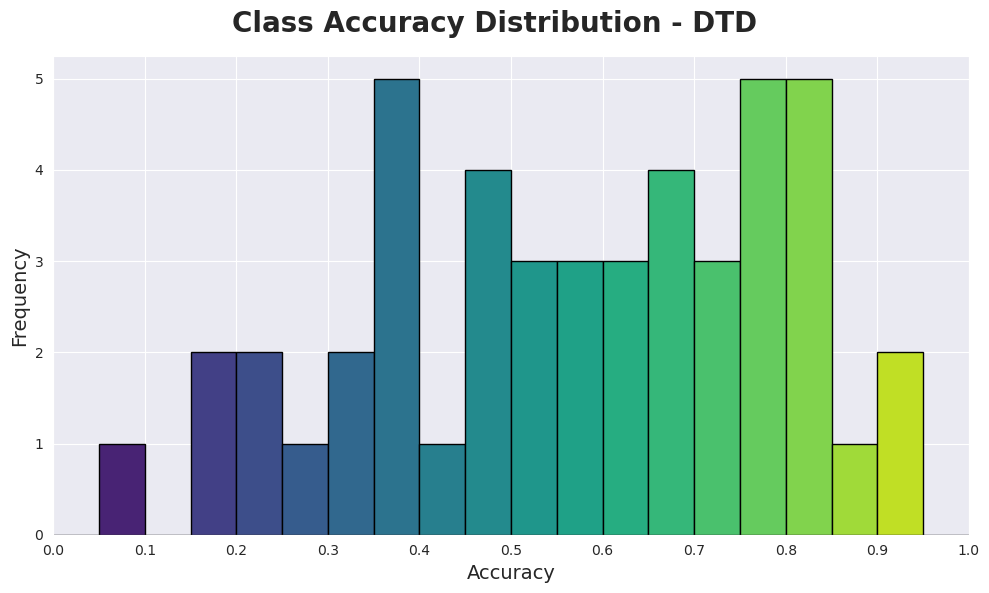

In [179]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=16)


Model is shown only 16 images per class from the dataset.

#### RESISC45

In [180]:
teacher_resisc45_16 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [181]:
get_model_params(teacher_resisc45_16)

Parameters: 80.70M


In [182]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45_16,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 90/90 [00:04<00:00, 20.00it/s]


Epochs: 1/10 | train_loss: 3.4618 | train_acc: 0.1639


100%|██████████| 90/90 [00:04<00:00, 20.02it/s]


Epochs: 2/10 | train_loss: 1.9173 | train_acc: 0.5125


100%|██████████| 90/90 [00:04<00:00, 20.03it/s]


Epochs: 3/10 | train_loss: 1.3407 | train_acc: 0.6944


100%|██████████| 90/90 [00:04<00:00, 20.05it/s]


Epochs: 4/10 | train_loss: 1.0685 | train_acc: 0.7458


100%|██████████| 90/90 [00:04<00:00, 20.03it/s]


Epochs: 5/10 | train_loss: 0.8436 | train_acc: 0.8000


100%|██████████| 90/90 [00:04<00:00, 19.98it/s]


Epochs: 6/10 | train_loss: 0.6705 | train_acc: 0.8542


100%|██████████| 90/90 [00:04<00:00, 20.08it/s]


Epochs: 7/10 | train_loss: 0.5610 | train_acc: 0.8944


100%|██████████| 90/90 [00:04<00:00, 19.96it/s]


Epochs: 8/10 | train_loss: 0.4819 | train_acc: 0.9069


100%|██████████| 90/90 [00:04<00:00, 20.07it/s]


Epochs: 9/10 | train_loss: 0.4243 | train_acc: 0.9222


100%|██████████| 90/90 [00:04<00:00, 19.97it/s]

Epochs: 10/10 | train_loss: 0.3720 | train_acc: 0.9389


In [183]:
deit_resisc45_16 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [184]:
get_model_params(deit_resisc45_16)

Parameters: 85.87M


In [185]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45_16,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_resisc45_16,
    few_shot=16
)

100%|██████████| 90/90 [00:10<00:00,  8.23it/s]


Epochs: 1/10 | train_loss: 3.0494 | train_acc: 0.2958


100%|██████████| 90/90 [00:10<00:00,  8.40it/s]


Epochs: 2/10 | train_loss: 1.4034 | train_acc: 0.7847


100%|██████████| 90/90 [00:10<00:00,  8.40it/s]


Epochs: 3/10 | train_loss: 0.7960 | train_acc: 0.9042


100%|██████████| 90/90 [00:10<00:00,  8.40it/s]


Epochs: 4/10 | train_loss: 0.5200 | train_acc: 0.9542


100%|██████████| 90/90 [00:10<00:00,  8.40it/s]


Epochs: 5/10 | train_loss: 0.3656 | train_acc: 0.9722


100%|██████████| 90/90 [00:10<00:00,  8.38it/s]


Epochs: 6/10 | train_loss: 0.2675 | train_acc: 0.9903


100%|██████████| 90/90 [00:10<00:00,  8.33it/s]


Epochs: 7/10 | train_loss: 0.2050 | train_acc: 0.9944


100%|██████████| 90/90 [00:10<00:00,  8.36it/s]


Epochs: 8/10 | train_loss: 0.1602 | train_acc: 0.9972


100%|██████████| 90/90 [00:10<00:00,  8.37it/s]


Epochs: 9/10 | train_loss: 0.1315 | train_acc: 1.0000


100%|██████████| 90/90 [00:10<00:00,  8.41it/s]

Epochs: 10/10 | train_loss: 0.1083 | train_acc: 0.9986


In [186]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45_16,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:07<00:00, 11.62it/s]

test_loss: 0.8778 | test_acc: 0.7548


In [187]:
resisc45_accs.append(resisc45_acc)

In [188]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9470198675496688),
 ('chaparral', 0.9318181818181818),
 ('snowberg', 0.9119496855345912),
 ('forest', 0.910958904109589),
 ('beach', 0.9076923076923077)]

In [189]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.42857142857142855),
 ('tennis court', 0.4791666666666667),
 ('basketball court', 0.5),
 ('intersection', 0.5461538461538461),
 ('railway', 0.5785714285714286)]

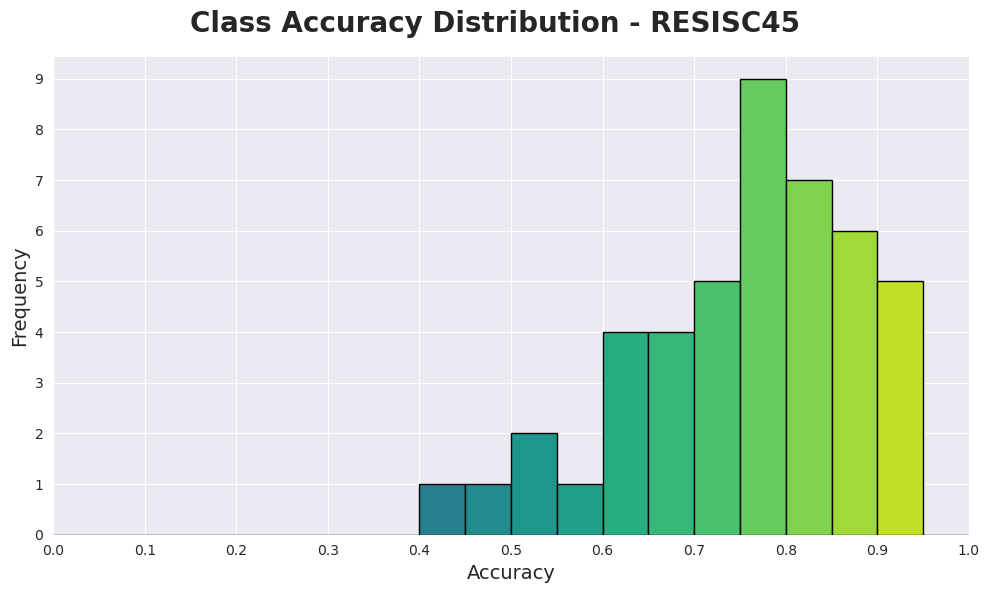

In [190]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [191]:
teacher_food101_16 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [192]:
get_model_params(teacher_food101_16)

Parameters: 80.87M


In [193]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101_16,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 202/202 [00:15<00:00, 13.19it/s]


Epochs: 1/10 | train_loss: 4.5239 | train_acc: 0.0804


100%|██████████| 202/202 [00:15<00:00, 13.16it/s]


Epochs: 2/10 | train_loss: 2.5622 | train_acc: 0.4127


100%|██████████| 202/202 [00:15<00:00, 13.19it/s]


Epochs: 3/10 | train_loss: 1.7227 | train_acc: 0.6225


100%|██████████| 202/202 [00:15<00:00, 13.17it/s]


Epochs: 4/10 | train_loss: 1.2265 | train_acc: 0.7413


100%|██████████| 202/202 [00:15<00:00, 12.75it/s]


Epochs: 5/10 | train_loss: 0.9304 | train_acc: 0.8187


100%|██████████| 202/202 [00:15<00:00, 13.22it/s]


Epochs: 6/10 | train_loss: 0.7308 | train_acc: 0.8595


100%|██████████| 202/202 [00:15<00:00, 13.19it/s]


Epochs: 7/10 | train_loss: 0.5543 | train_acc: 0.9103


100%|██████████| 202/202 [00:15<00:00, 13.18it/s]


Epochs: 8/10 | train_loss: 0.4543 | train_acc: 0.9344


100%|██████████| 202/202 [00:15<00:00, 13.20it/s]


Epochs: 9/10 | train_loss: 0.3408 | train_acc: 0.9610


100%|██████████| 202/202 [00:15<00:00, 13.21it/s]

Epochs: 10/10 | train_loss: 0.3263 | train_acc: 0.9493


In [194]:
deit_food101_16 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [195]:
get_model_params(deit_food101_16)

Parameters: 85.96M


In [196]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101_16,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_food101_16,
    few_shot=16
)

100%|██████████| 202/202 [00:29<00:00,  6.95it/s]


Epochs: 1/10 | train_loss: 3.7738 | train_acc: 0.2364


100%|██████████| 202/202 [00:28<00:00,  6.98it/s]


Epochs: 2/10 | train_loss: 1.9085 | train_acc: 0.6801


100%|██████████| 202/202 [00:29<00:00,  6.96it/s]


Epochs: 3/10 | train_loss: 1.1564 | train_acc: 0.8199


100%|██████████| 202/202 [00:28<00:00,  7.01it/s]


Epochs: 4/10 | train_loss: 0.7758 | train_acc: 0.9059


100%|██████████| 202/202 [00:29<00:00,  6.90it/s]


Epochs: 5/10 | train_loss: 0.5451 | train_acc: 0.9400


100%|██████████| 202/202 [00:29<00:00,  6.92it/s]


Epochs: 6/10 | train_loss: 0.3927 | train_acc: 0.9666


100%|██████████| 202/202 [00:29<00:00,  6.96it/s]


Epochs: 7/10 | train_loss: 0.2911 | train_acc: 0.9858


100%|██████████| 202/202 [00:29<00:00,  6.95it/s]


Epochs: 8/10 | train_loss: 0.2191 | train_acc: 0.9938


100%|██████████| 202/202 [00:29<00:00,  6.91it/s]


Epochs: 9/10 | train_loss: 0.1701 | train_acc: 0.9969


100%|██████████| 202/202 [00:29<00:00,  6.89it/s]

Epochs: 10/10 | train_loss: 0.1348 | train_acc: 0.9975


In [197]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101_16,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:54<00:00,  8.90it/s]


test_loss: 1.5197 | test_acc: 0.5979


In [198]:
food101_accs.append(food101_acc)

In [199]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.976),
 ('spaghetti carbonara', 0.956),
 ('hot and sour soup', 0.908),
 ('pizza', 0.908),
 ('guacamole', 0.9)]

In [200]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.2),
 ('ravioli', 0.224),
 ('scallops', 0.276),
 ('foie gras', 0.284),
 ('tuna tartare', 0.3)]

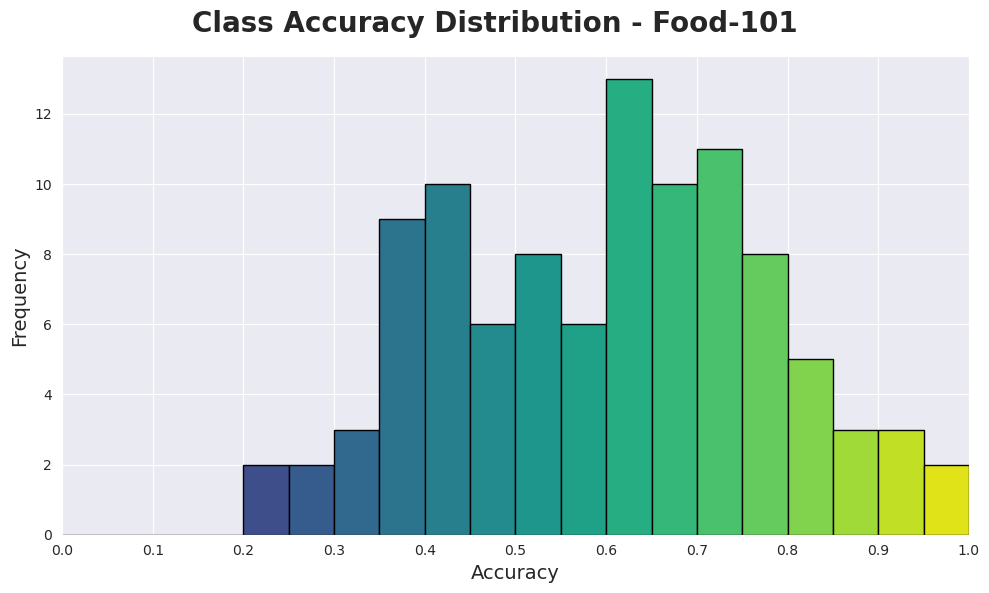

In [201]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [202]:
teacher_fer2013_16 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [203]:
get_model_params(teacher_fer2013_16)

Parameters: 80.59M


In [204]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013_16,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 14/14 [00:00<00:00, 18.85it/s]


Epochs: 1/10 | train_loss: 2.0295 | train_acc: 0.1071


100%|██████████| 14/14 [00:00<00:00, 18.94it/s]


Epochs: 2/10 | train_loss: 1.8505 | train_acc: 0.3036


100%|██████████| 14/14 [00:00<00:00, 18.84it/s]


Epochs: 3/10 | train_loss: 1.6363 | train_acc: 0.5268


100%|██████████| 14/14 [00:00<00:00, 18.98it/s]


Epochs: 4/10 | train_loss: 1.4871 | train_acc: 0.5179


100%|██████████| 14/14 [00:00<00:00, 19.10it/s]


Epochs: 5/10 | train_loss: 1.3357 | train_acc: 0.6607


100%|██████████| 14/14 [00:00<00:00, 19.05it/s]


Epochs: 6/10 | train_loss: 1.2154 | train_acc: 0.6875


100%|██████████| 14/14 [00:00<00:00, 18.92it/s]


Epochs: 7/10 | train_loss: 1.0703 | train_acc: 0.8036


100%|██████████| 14/14 [00:00<00:00, 19.11it/s]


Epochs: 8/10 | train_loss: 1.0923 | train_acc: 0.7768


100%|██████████| 14/14 [00:00<00:00, 19.00it/s]


Epochs: 9/10 | train_loss: 0.9892 | train_acc: 0.8125


100%|██████████| 14/14 [00:00<00:00, 19.30it/s]

Epochs: 10/10 | train_loss: 0.9558 | train_acc: 0.8125


In [205]:
deit_fer2013_16 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [206]:
get_model_params(deit_fer2013_16)

Parameters: 85.81M


In [207]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013_16,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_fer2013_16,
    few_shot=16
)

100%|██████████| 14/14 [00:01<00:00,  8.22it/s]


Epochs: 1/10 | train_loss: 2.0964 | train_acc: 0.1786


100%|██████████| 14/14 [00:01<00:00,  8.22it/s]


Epochs: 2/10 | train_loss: 1.8200 | train_acc: 0.2589


100%|██████████| 14/14 [00:01<00:00,  8.20it/s]


Epochs: 3/10 | train_loss: 1.6186 | train_acc: 0.4911


100%|██████████| 14/14 [00:01<00:00,  8.22it/s]


Epochs: 4/10 | train_loss: 1.4515 | train_acc: 0.5536


100%|██████████| 14/14 [00:01<00:00,  8.21it/s]


Epochs: 5/10 | train_loss: 1.3256 | train_acc: 0.6250


100%|██████████| 14/14 [00:01<00:00,  8.23it/s]


Epochs: 6/10 | train_loss: 1.2266 | train_acc: 0.6786


100%|██████████| 14/14 [00:01<00:00,  8.24it/s]


Epochs: 7/10 | train_loss: 1.1397 | train_acc: 0.7500


100%|██████████| 14/14 [00:01<00:00,  8.21it/s]


Epochs: 8/10 | train_loss: 1.0899 | train_acc: 0.7500


100%|██████████| 14/14 [00:01<00:00,  8.22it/s]


Epochs: 9/10 | train_loss: 1.0004 | train_acc: 0.7679


100%|██████████| 14/14 [00:01<00:00,  8.22it/s]

Epochs: 10/10 | train_loss: 0.9411 | train_acc: 0.8036


In [208]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013_16,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:39<00:00, 11.30it/s]

test_loss: 1.7729 | test_acc: 0.3168


In [209]:
fer2013_accs.append(fer2013_acc)

In [210]:
fer2013_per_class_acc

{'angry': 0.3380855397148676,
 'disgust': 0.43636363636363634,
 'fear': 0.17424242424242425,
 'happy': 0.46188850967007966,
 'sad': 0.28114478114478114,
 'surprise': 0.3701923076923077,
 'neutral': 0.20447284345047922}

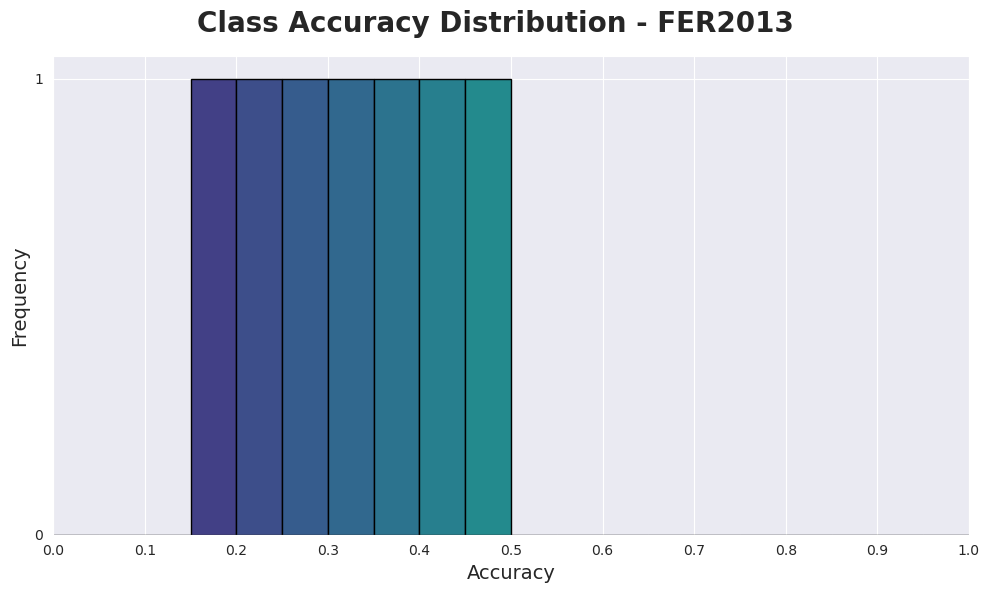

In [211]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [212]:
teacher_pcam_16 = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [213]:
get_model_params(teacher_pcam_16)

Parameters: 80.57M


In [214]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam_16,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 4/4 [00:00<00:00, 18.10it/s]


Epochs: 1/10 | train_loss: 0.8028 | train_acc: 0.4062


100%|██████████| 4/4 [00:00<00:00, 18.79it/s]


Epochs: 2/10 | train_loss: 0.7824 | train_acc: 0.5625


100%|██████████| 4/4 [00:00<00:00, 18.93it/s]


Epochs: 3/10 | train_loss: 0.6093 | train_acc: 0.6875


100%|██████████| 4/4 [00:00<00:00, 18.85it/s]


Epochs: 4/10 | train_loss: 0.6402 | train_acc: 0.5938


100%|██████████| 4/4 [00:00<00:00, 19.16it/s]


Epochs: 5/10 | train_loss: 0.5368 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 19.22it/s]


Epochs: 6/10 | train_loss: 0.4945 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 18.81it/s]


Epochs: 7/10 | train_loss: 0.4185 | train_acc: 0.8750


100%|██████████| 4/4 [00:00<00:00, 18.90it/s]


Epochs: 8/10 | train_loss: 0.3968 | train_acc: 0.7500


100%|██████████| 4/4 [00:00<00:00, 18.99it/s]


Epochs: 9/10 | train_loss: 0.4172 | train_acc: 0.8125


100%|██████████| 4/4 [00:00<00:00, 19.00it/s]

Epochs: 10/10 | train_loss: 0.3711 | train_acc: 0.9062


In [215]:
deit_pcam_16 = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [216]:
get_model_params(deit_pcam_16)

Parameters: 85.80M


In [217]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam_16,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True, 
    teacher=teacher_pcam_16,
    few_shot=16
)

100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Epochs: 1/10 | train_loss: 0.6960 | train_acc: 0.5312


100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Epochs: 2/10 | train_loss: 0.5864 | train_acc: 0.7188


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Epochs: 3/10 | train_loss: 0.5161 | train_acc: 0.8438


100%|██████████| 4/4 [00:00<00:00,  8.09it/s]


Epochs: 4/10 | train_loss: 0.4568 | train_acc: 0.8438


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Epochs: 5/10 | train_loss: 0.4113 | train_acc: 0.8438


100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


Epochs: 6/10 | train_loss: 0.3740 | train_acc: 0.8750


100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


Epochs: 7/10 | train_loss: 0.3465 | train_acc: 0.8750


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Epochs: 8/10 | train_loss: 0.3254 | train_acc: 0.8750


100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Epochs: 9/10 | train_loss: 0.3070 | train_acc: 0.8750


100%|██████████| 4/4 [00:00<00:00,  8.09it/s]

Epochs: 10/10 | train_loss: 0.2905 | train_acc: 0.8750


In [218]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam_16,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:05<00:00, 11.22it/s]

test_loss: 0.5573 | test_acc: 0.7192


In [219]:
pcam_accs.append(pcam_acc)

In [220]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.7981209200170826,
 'lymph node tumor tissue': 0.6402271478292728}

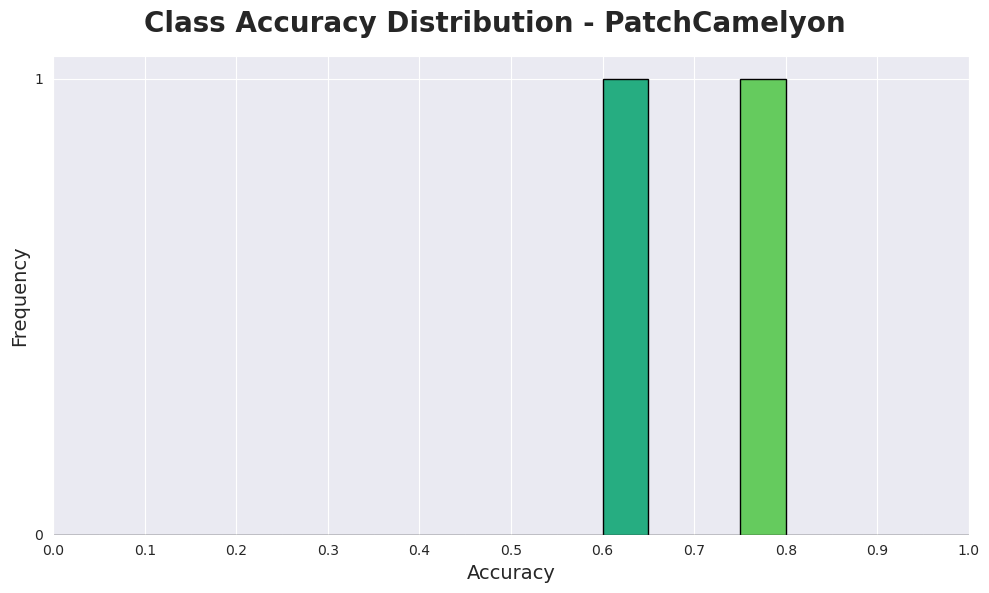

In [221]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [222]:
teacher_sun397_16 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [223]:
get_model_params(teacher_sun397_16)

Parameters: 81.77M


In [224]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397_16,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 794/794 [01:01<00:00, 12.83it/s]


Epochs: 1/10 | train_loss: 4.4887 | train_acc: 0.1631


100%|██████████| 794/794 [01:01<00:00, 12.98it/s]


Epochs: 2/10 | train_loss: 1.9293 | train_acc: 0.5121


100%|██████████| 794/794 [01:01<00:00, 12.95it/s]


Epochs: 3/10 | train_loss: 1.2194 | train_acc: 0.6636


100%|██████████| 794/794 [01:00<00:00, 13.02it/s]


Epochs: 4/10 | train_loss: 0.9027 | train_acc: 0.7480


100%|██████████| 794/794 [01:00<00:00, 13.02it/s]


Epochs: 5/10 | train_loss: 0.7228 | train_acc: 0.7955


100%|██████████| 794/794 [01:00<00:00, 13.03it/s]


Epochs: 6/10 | train_loss: 0.5516 | train_acc: 0.8415


100%|██████████| 794/794 [01:01<00:00, 12.87it/s]


Epochs: 7/10 | train_loss: 0.5040 | train_acc: 0.8553


100%|██████████| 794/794 [01:01<00:00, 12.98it/s]


Epochs: 8/10 | train_loss: 0.4389 | train_acc: 0.8737


100%|██████████| 794/794 [01:01<00:00, 13.01it/s]


Epochs: 9/10 | train_loss: 0.3945 | train_acc: 0.8873


100%|██████████| 794/794 [01:01<00:00, 12.99it/s]


Epochs: 10/10 | train_loss: 0.3609 | train_acc: 0.8936


In [225]:
deit_sun397_16 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [226]:
get_model_params(deit_sun397_16)

Parameters: 86.41M


In [227]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397_16,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_sun397_16,
    few_shot=16
)

100%|██████████| 794/794 [01:56<00:00,  6.79it/s]


Epochs: 1/10 | train_loss: 3.6447 | train_acc: 0.3349


100%|██████████| 794/794 [01:56<00:00,  6.83it/s]


Epochs: 2/10 | train_loss: 1.0150 | train_acc: 0.7884


100%|██████████| 794/794 [01:56<00:00,  6.84it/s]


Epochs: 3/10 | train_loss: 0.4672 | train_acc: 0.9161


100%|██████████| 794/794 [01:56<00:00,  6.84it/s]


Epochs: 4/10 | train_loss: 0.2561 | train_acc: 0.9581


100%|██████████| 794/794 [01:56<00:00,  6.83it/s]


Epochs: 5/10 | train_loss: 0.1632 | train_acc: 0.9721


100%|██████████| 794/794 [01:56<00:00,  6.82it/s]


Epochs: 6/10 | train_loss: 0.1235 | train_acc: 0.9776


100%|██████████| 794/794 [01:56<00:00,  6.84it/s]


Epochs: 7/10 | train_loss: 0.1114 | train_acc: 0.9761


100%|██████████| 794/794 [01:56<00:00,  6.84it/s]


Epochs: 8/10 | train_loss: 0.1038 | train_acc: 0.9764


100%|██████████| 794/794 [01:56<00:00,  6.81it/s]


Epochs: 9/10 | train_loss: 0.1042 | train_acc: 0.9786


100%|██████████| 794/794 [01:56<00:00,  6.82it/s]


Epochs: 10/10 | train_loss: 0.1015 | train_acc: 0.9769


In [228]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397_16,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:11<00:00,  8.72it/s]


test_loss: 1.7686 | test_acc: 0.5684


In [229]:
sun397_accs.append(sun397_acc)

In [230]:
get_top_5_accuracies(sun397_per_class_acc)

[('raft', 1.0),
 ('rock arch', 1.0),
 ('volcano', 1.0),
 ('underwater (coral reef)', 0.9913793103448276),
 ('wine cellar (barrel storage)', 0.9803921568627451)]

In [231]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('recreation room', 0.037037037037037035),
 ('balcony (interior)', 0.058823529411764705),
 ('courtyard', 0.08333333333333333),
 ('biology laboratory', 0.09090909090909091),
 ('physics laboratory', 0.0967741935483871)]

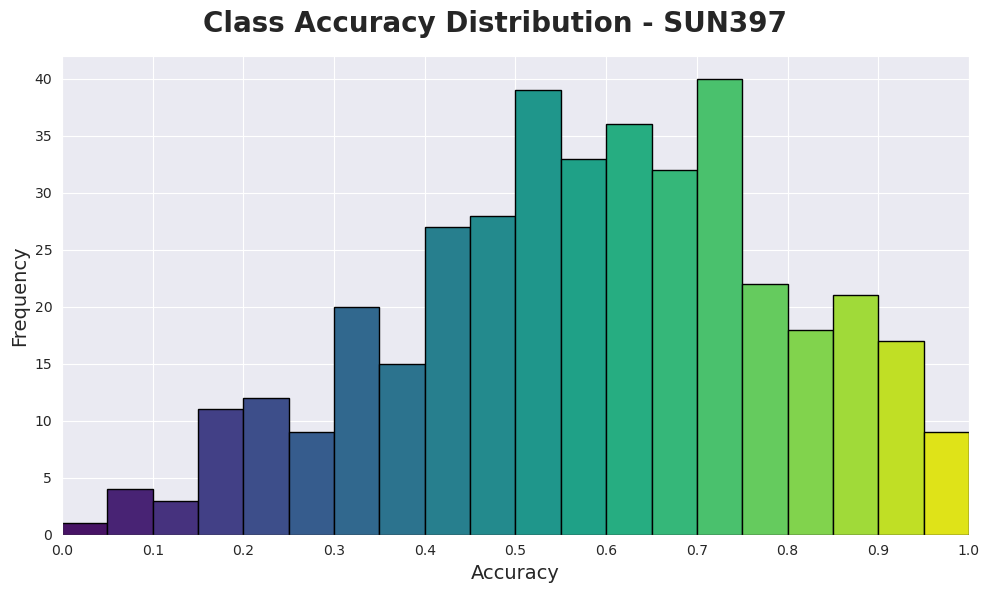

In [232]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [233]:
teacher_dtd_16 = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [234]:
get_model_params(teacher_dtd_16)

Parameters: 80.71M


In [235]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd_16,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 94/94 [00:07<00:00, 12.09it/s]


Epochs: 1/10 | train_loss: 3.1923 | train_acc: 0.2274


100%|██████████| 94/94 [00:07<00:00, 12.06it/s]


Epochs: 2/10 | train_loss: 1.7959 | train_acc: 0.5173


100%|██████████| 94/94 [00:07<00:00, 12.01it/s]


Epochs: 3/10 | train_loss: 1.3886 | train_acc: 0.6303


100%|██████████| 94/94 [00:07<00:00, 12.01it/s]


Epochs: 4/10 | train_loss: 1.1404 | train_acc: 0.6902


100%|██████████| 94/94 [00:07<00:00, 12.05it/s]


Epochs: 5/10 | train_loss: 1.0469 | train_acc: 0.7168


100%|██████████| 94/94 [00:07<00:00, 11.99it/s]


Epochs: 6/10 | train_loss: 0.9123 | train_acc: 0.7540


100%|██████████| 94/94 [00:07<00:00, 11.90it/s]


Epochs: 7/10 | train_loss: 0.8411 | train_acc: 0.7620


100%|██████████| 94/94 [00:07<00:00, 12.04it/s]


Epochs: 8/10 | train_loss: 0.7084 | train_acc: 0.7965


100%|██████████| 94/94 [00:07<00:00, 12.04it/s]


Epochs: 9/10 | train_loss: 0.6204 | train_acc: 0.8298


100%|██████████| 94/94 [00:07<00:00, 12.00it/s]

Epochs: 10/10 | train_loss: 0.6580 | train_acc: 0.8231


In [236]:
deit_dtd_16 = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [237]:
get_model_params(deit_dtd_16)

Parameters: 85.87M


In [238]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd_16,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_dtd_16,
    few_shot=16
)

100%|██████████| 94/94 [00:14<00:00,  6.52it/s]


Epochs: 1/10 | train_loss: 3.1704 | train_acc: 0.2846


100%|██████████| 94/94 [00:14<00:00,  6.44it/s]


Epochs: 2/10 | train_loss: 1.6151 | train_acc: 0.7380


100%|██████████| 94/94 [00:14<00:00,  6.59it/s]


Epochs: 3/10 | train_loss: 0.9712 | train_acc: 0.8577


100%|██████████| 94/94 [00:14<00:00,  6.58it/s]


Epochs: 4/10 | train_loss: 0.6568 | train_acc: 0.9176


100%|██████████| 94/94 [00:14<00:00,  6.57it/s]


Epochs: 5/10 | train_loss: 0.4815 | train_acc: 0.9388


100%|██████████| 94/94 [00:14<00:00,  6.53it/s]


Epochs: 6/10 | train_loss: 0.3739 | train_acc: 0.9535


100%|██████████| 94/94 [00:14<00:00,  6.57it/s]


Epochs: 7/10 | train_loss: 0.3031 | train_acc: 0.9548


100%|██████████| 94/94 [00:14<00:00,  6.56it/s]


Epochs: 8/10 | train_loss: 0.2506 | train_acc: 0.9654


100%|██████████| 94/94 [00:14<00:00,  6.55it/s]


Epochs: 9/10 | train_loss: 0.2142 | train_acc: 0.9641


100%|██████████| 94/94 [00:14<00:00,  6.44it/s]

Epochs: 10/10 | train_loss: 0.1858 | train_acc: 0.9668


In [239]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd_16,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:26<00:00,  8.80it/s]

test_loss: 1.4846 | test_acc: 0.6138


In [240]:
dtd_accs.append(dtd_acc)

In [241]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.95),
 ('potholed', 0.95),
 ('cobwebbed', 0.925),
 ('knitted', 0.925),
 ('scaly', 0.9)]

In [242]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.175),
 ('woven', 0.175),
 ('bumpy', 0.3),
 ('marbled', 0.3),
 ('pitted', 0.35)]

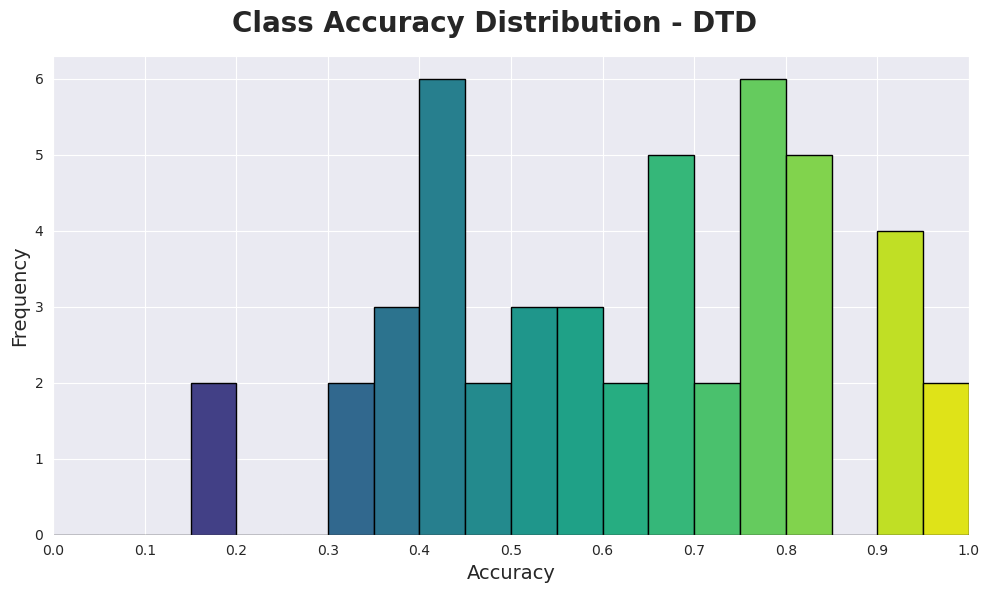

In [243]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [5]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [6]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']
n_shots = [1, 2, 4, 8, 16]

In [7]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [8]:
df = pd.DataFrame(results, columns=[f"{n}-shot linear probe" for n in n_shots], index=labels)
df

,1-shot linear probe,2-shot linear probe,4-shot linear probe,8-shot linear probe,16-shot linear probe
RESISC45,0.304762,0.458095,0.594127,0.689206,0.754762
Food-101,0.198495,0.301386,0.425941,0.520871,0.597901
FER2013,0.173865,0.152689,0.186960,0.160490,0.316801
PatchCamelyon,0.493317,0.520508,0.540375,0.718689,0.719208
SUN397,0.255264,0.377425,0.470023,0.541471,0.568368
DTD,0.261170,0.365426,0.465957,0.556915,0.613830
